# Strategy

## What is the best property profile to invest in the city?
Focusing on Seazone's business, we can asnwer this in the shoes of:
- a Real Estate investor thinking about buying an apartment to rent -> we can narrow this as well, based on how much the investor is willing to spend
- a project developer (this will be answered in one of the next questions)

The "profile" would be the type of real estate (apartment, house, apart-hotel etc), number of bedrooms, bathrooms, parking spaces, location (location, location, location!), ammenities, how fast it can be rented ...

## Which is the best location in the city in terms of revenue?
We will analyze Short-Stay revenue, but also buy/sell revenue. This can be also analyzed in terms of rental return (price of the real estate vs rent).

It's important to note that revenue is also dependant on vacancy (not only rental price), and I need to understand how to get that data from the datasets.

We will try to select a part of a neighbourhood or at least the whole neighbourhood. It would be great to 

## What are the characteristics and reasons for the best revenues in the city?
This is an extension of the last question. After determining the best location, we analyze this location.

## We would like to build a building of 50 apartments in the city, where should we build it and how should the apartments be designed in order to be a great investment?
In other words, we have to analyze the best revenue (or rental return) apartments in the whole city, because not necessarily the best location of the last question will have available space for a new construction (or it could be financially too expensive).

In the last question we already analyzed a specific location in terms of characteriscts and reasons for it to have the best revenue. We will repeat this here, but for different locations across the city, and try to see what are the common characteristics in the whole city. These will be the characteristics that we will also use.

I think that we need to see pictures of the best buildings as well and not only work with text data. This way we can understand architectural characteristics that are not available on either Airbnb or Vivareal text datasets. I will see pictures of the top 50 revenue (or rental return) in the city.



## How much will be the return on investment of this building in the years 2024, 2025 and 2026?
This is a really broad question. 

First of all, I don't think the building would be complete, with the "Habite-se" available in 2024 to generate any return yet. 

But assuming it is ready by the end of 2023 and people start to rent it in the beginning of 2024 (summer time!). 

We need to predict how much it will cost and calculate ROI based on that.

"Nosso prazo de pagamento é de até 36 meses"



Perguntas para fazer:
- no modelo de compra, o proprietário compra um imóvel incorporado/construído pela Seazone, depois deixa alugado na própria Seazone, que também possui Anfitriões para cuidar das operações "de campo"?

# 0) Import libraries

In [1]:
!pip install matplotlib --upgrade
!pip install python-geohash
!python -m pip install --upgrade dask[distributed]
!pip install folium==0.12.0
!pip install python-slugify
!pip install selenium

import os
import io

import numpy as np
import math
import re
from itertools import chain
from slugify import slugify

import pandas as pd
from dask.distributed import Client
import dask
import dask.dataframe as dd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import folium
import branca
import branca.colormap as cm
from PIL import Image
import selenium

import geohash as gh

In [83]:
dask.__version__

'2022.12.1'

# 1) ETL methods
Import, understand, clean, transform

## Airbnb Locations
We will check if the locations on both tables (airbnb_listings and airbnb_locations) are the same. If not, we will stick to "airbnb_locations" latituge and longitude, because it is said that "It is the most reliable data to infer the location of a listing".

In [2]:
def get_airbnb_locations():
    
    # Read .csv
    airbnb_locations_raw = \
        pd.read_csv("../data/raw/Mesh_Ids_Data_Itapema.csv") # add dtype
    
    # clean and format data
    airbnb_locations = clean_airbnb_locations(airbnb_locations_raw)
    
    return airbnb_locations

In [3]:
def clean_airbnb_locations(df):
    
    # Drop duplicates, keeping the last one aquired by the scraper
    df.sort_values('aquisition_date', ascending=False, inplace=True)
    df.drop_duplicates(subset='airbnb_listing_id', inplace=True)
    
    return df

In [4]:
# airbnb_locations = get_airbnb_locations()

In [5]:
def replace_lat_lon(df1, df2):
    """ Replaces latitude and longitude of df1 with the ones in df2
    
        Returns df1
    """
    
    # Drop the original latitude and longitude columns
    df1.drop(labels = ['latitude', 'longitude'], axis=1, inplace = True)
    
    # Merge with df2 latitude and longitude
    df1 = df1.merge(df2[['airbnb_listing_id','latitude','longitude']], left_on = 'ad_id', right_on = 'airbnb_listing_id')
    df1.drop('airbnb_listing_id', axis=1, inplace = True)
    
    return df1

In [6]:
# airbnb_listings = replace_lat_lon(airbnb_listings, airbnb_locations)

In [7]:
def include_geohash(df, p):
    
    # Encodes lat/lon with a geohash of precision p
    df[f'geohash{p}'] = df.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=p), axis=1)

    return df

In [8]:
# airbnb_listings = include_geohash(airbnb_listings, 6)
# airbnb_listings = include_geohash(airbnb_listings, 7)

## Airbnb Listing

In [9]:
def make_comma_separable(x):
    # convert unformatted strings to a comma separable format
    
    #print(x)
    #print(type(x))
    x = re.sub(r"[\[\]]", "", x) # remove '[' and ']'
    x = re.sub(r"[\{\}]", "", x) # remove '{' and '}'
    
    x = re.sub(r"", "", x) # remove '{' and '}'
    
    x = x.replace('"', '') # remove '"'
    
    
    
    if '\\' in x:
        x = x.replace(',,,', ',;,')
        x = x.replace(',', '')
        x = x.replace(';', ',')
        x = x.replace('\\\\', '|')
        x = x.replace('\\', '')
        x = x.replace('|', '\\')
        x = x.encode('utf-8').decode('unicode-escape')
        
    x = x.replace(', ', ',')    
    
    return x

In [10]:
def add_full_text(x):
    # convert single expressions to the complete category string
    x = x.replace(",lockbox", ",Self check-in com lockbox")
    
    return x

In [11]:
def create_one_hot_encoding(df, columns_to_encode):
    # Creates one hot encoding for a list of columns
    # return a df with the encoded columns and a list of the encoded columns names
    encoded_columns = []
    
    for col in columns_to_encode:
        df[col] = df[col].fillna("")
        df[col] = df[col].str.replace("{n,u,l,l}","") # ugly, needs to improve
        df[col] = df[col].apply(make_comma_separable)
        df[col] = df[col].apply(add_full_text) # ugly, needs to improve
        
        one_hot = df[col].str.get_dummies(sep=',').astype(np.bool_) # creates one hot encoding
        encoded_columns.append(one_hot.columns.values.tolist())
        
        df = df.drop(col, axis = 1) # original column can now be dropped
        
        df = df.combine_first(one_hot)
        # df = df.merge(one_hot, left_index=True, right_index=True)
        
    encoded_columns = list(chain.from_iterable(encoded_columns))
    encoded_columns = list(dict.fromkeys(encoded_columns)) # removes duplicate column names 
    return df, encoded_columns

In [12]:
def get_airbnb_listings():
    
    dtype = {'aquisition_date': str,
            'url': str,
            'ad_name': str,
            'ad_description': str,
            'ad_id': np.int_,
            'space': str,
            'house_rules': str,
            'amenities': str,
            'safety_features': str,
            'number_of_bathrooms': pd.UInt8Dtype(),
            'number_of_bedrooms': pd.UInt8Dtype(),
            'number_of_beds': pd.UInt8Dtype(),
            'latitude': np.float64,
            'longitude': np.float64,
            'star_rating': np.float16,
            'additional_house_rules': str,
            'owner': str,
            'check_in': str,
            'check_out': str,
            'number_of_guests': pd.UInt8Dtype(),
            'is_superhost': np.bool_,
            'number_of_reviews': pd.UInt16Dtype(),
            'cohosts': str,
            'cleaning_fee': np.float16,
            'can_instant_book': np.bool_,
            'owner_id': np.int_,
            'listing_type': str,
            'index': pd.UInt64Dtype(),
            'localized_star_rating': str,  # decimal separator is comma ',', need to change to dot '.'
            'response_time_shown': str,
            'response_rate_shown': str,
            'guest_satisfaction_overall': np.float16,
            'picture_count': pd.UInt8Dtype(),
            'min_nights': pd.UInt64Dtype(),
            'ano': pd.UInt16Dtype(),
            'mes': pd.UInt8Dtype(),
            'dia': pd.UInt8Dtype()}
    
    # Read .csv
    airbnb_listings_raw = pd.read_csv("../data/raw/Details_Data.csv", 
                                        na_values='',
                                        dtype=dtype)

    # Clean and format data
    airbnb_listings = clean_airbnb_listings(airbnb_listings_raw)
    
    # Create one-hot-encodings
    columns_to_encode = ['safety_features', 'house_rules', 'amenities']
    airbnb_listings, encoded_columns = create_one_hot_encoding(airbnb_listings, columns_to_encode)
    
    return airbnb_listings, encoded_columns

In [13]:
def clean_airbnb_listings(df):
    
    # replace ',' to '.' on localized_star_rating, then convert to float
    df['localized_star_rating'] = \
        pd.to_numeric(
            df['localized_star_rating'].str.replace(',', '.'), downcast='float'
            )
    
    # format aquisition date as datetime
    df['aquisition_date'] = \
        pd.to_datetime(df['aquisition_date'], format="%Y-%m-%d %H:%M:%S")
    
    # Drop duplicates, keeping the last one aquired by the scraper
    # DISCLAIMER: doing so removes some information on listings, for example, 'min_nights' 
    # for all of the latest aquired listings is <NA>, even though it wasn't in the beginning
    df.sort_values('aquisition_date', ascending=False, inplace=True)
    df.drop_duplicates(subset='ad_id', inplace=True)
    
    return df

## Airbnb price and availability

In [14]:
def get_airbnb_price_av():
    
    # After some inspection the following features were confirmed being all NA: 
    # av_for_checkout, index and bookable, therefore they will not be used
    data_columns = ["airbnb_listing_id", "date", "price",
                    "price_string", "minimum_stay", "available",
                    "aquisition_date", "av_for_checkin", #"av_for_checkout",
                    #"index", "bookable", 
                    "ano", "mes", "dia"] 

    dtypes=    {"airbnb_listing_id": np.uint64, 
                 "date": str,
                 "price": np.float_, 
                 "price_string": str,
                 "minimum_stay": np.uint16,
                 "available": np.bool_,
                 "aquisition_date": str,
                 "av_for_checkin": str, #np.bool_,
                 #"av_for_checkout": bool,
                 #"index": str,
                 #"bookable": str,
                 "ano": np.uint16,
                 "mes": np.uint8,
                 "dia": np.uint8 }
    
    date_columns = ['date', 'aquisition_date']
    
    airbnb_price_raw = dd.read_csv("../data/raw/Price_AV_Itapema-001.csv",
                                    usecols=data_columns,
                                    dtype=dtypes, 
                                    parse_dates=date_columns)
    
    airbnb_price_av = clean_airbnb_price_av(airbnb_price_raw)
    
    return airbnb_price_av

In [15]:
def clean_airbnb_price_av(df):
    
    # Column 'price' has a small amount of NaN, we can safely drop it
    df = df.dropna(subset='price')
    
    # Column 'av_for_checkin' has small amount of NaN, we can safely drop it
    df = df.dropna(subset='av_for_checkin')
    
    # There are a lot of typos in the 'price_string', creating unrealistic prices.
    # Drop any 'price' greater than R$100.000 to parcially solve it.
    df = df[df['price'] < 100000]
    
    return df

In [16]:
# airbnb_price_av = get_airbnb_price_av()

In [17]:
def calculate_availability_rate(df):
    
    # Calculate how many days were Available or Not available for each listing
    series_av = (df
                .groupby('airbnb_listing_id')['available']
                .value_counts()
                .compute())
    
    # Transform previous value_counts series into a Dataframe
    df_av = (series_av
                .unstack(-1)                    
                .fillna(0)                       
                .add_prefix('available_')
                .reset_index())
    
    # Calculates availability rate
    df_av['availability_rate'] = df_av['available_True']/(df_av['available_True'] + df_av['available_False'])
    
    df_av_subset = df_av[['airbnb_listing_id', 'availability_rate']]
    
    return df_av_subset

In [18]:
# airbnb_listings_av_rate = calculate_availability_rate(airbnb_price_av)

In [19]:
def include_availability(df1, df2):
    
    # Includes df2 availability_rate colum into df1
    df1 = df1.merge(df2, left_on='ad_id', right_on='airbnb_listing_id')
    
    return df1

In [20]:
# airbnb_listings = include_availability(airbnb_listings, airbnb_listings_av_rate)

In [21]:
def dd_mode():
    """ Creates a Dask Dataframe Aggregation to calculate mode """

    def chunk(s):
        # for the comments, assume only a single grouping column, the 
        # implementation can handle multiple group columns.
        #
        # s is a grouped series. value_counts creates a multi-series like 
        # (group, value): count
        return s.value_counts()


    def agg(s):
    #     print('agg',s.apply(lambda s: s.groupby(level=-1).sum()))
        # s is a grouped multi-index series. In .apply the full sub-df will passed
        # multi-index and all. Group on the value level and sum the counts. The
        # result of the lambda function is a series. Therefore, the result of the 
        # apply is a multi-index series like (group, value): count
        return s.apply(lambda s: s.groupby(level=-1).sum())

        # faster version using pandas internals
        s = s._selected_obj
        return s.groupby(level=list(range(s.index.nlevels))).sum()


    def finalize(s):
        # s is a multi-index series of the form (group, value): count. First
        # manually group on the group part of the index. The lambda will receive a
        # sub-series with multi index. Next, drop the group part from the index.
        # Finally, determine the index with the maximum value, i.e., the mode.
        level = list(range(s.index.nlevels - 1))
        return (
            s.groupby(level=level)
            .apply(lambda s: s.reset_index(level=level, drop=True).idxmax())
        )

    mode = dd.Aggregation('mode', chunk, agg, finalize)
    
    return mode

In [22]:
def calculate_avg_price(df, avg_func):
    
    df_avg_price = df.groupby(['airbnb_listing_id']).agg({'price': avg_func}).compute()
    df_avg_price.rename(columns={'price':'mode_price'}, inplace=True)

    return df_avg_price

In [23]:
# avg_func = dd_mode()
# airbnb_listings_mode_price = calculate_mode_price(airbnb_price_av, avg_func)

In [24]:
def include_avg_price(df1, df2):
    
    # Includes df2 availability_rate colum into df1
    df1 = df1.merge(df2, left_on='ad_id', right_on='airbnb_listing_id')
    
    return df1

In [25]:
# airbnb_listings = include_avg_price(airbnb_listings, airbnb_listings_mode_price)

In [26]:
def get_least_available_airbnb_listings(df):
    
    # Select only the least available listings
    least_available_df = df.loc[df['availability_rate'] <= 0.1]
    
    return least_available_df

In [27]:
def get_apartments(df):
    
    # It was observed that the most common listing type is the apartment
    df_apartments = df.loc[\
                           df['listing_type']=='Espaço inteiro: apartamento']

    df_apartments.reset_index(drop = True, inplace = True)
    
    return df_apartments

In [28]:
# least_available_airbnb_listings = \
#     get_least_available_airbnb_listings(airbnb_listings)

In [29]:
# least_available_airbnb_apartments = \
#     get_apartments(least_available_airbnb_listings)

In [30]:
def get_top_booked_airbnb_listings(df, min_reviews):
    
    # Select only the top booked listings
    top_booked_df = df.loc[df['number_of_reviews'] >= min_reviews]
    
    return top_booked_df

In [31]:
# top_booked_airbnb_listings = get_top_booked_airbnb_listings(airbnb_listings, 50)

In [32]:
# top_booked_airbnb_apartments = get_apartments(top_booked_airbnb_listings)

## Airbnb Hosts

In [33]:
# airbnb_hosts = pd.read_csv("../data/raw/Hosts_ids_Itapema.csv")

In [34]:
# airbnb_hosts

## VivaReal listings

In [35]:
def get_vivareal_listings():
    
    # Read .csv
    vivareal_listings_raw = pd.read_csv("../data/raw/VivaReal_Itapema.csv")
    
    vivareal_listings = get_price_sqm(vivareal_listings_raw)
    
    vivareal_listings = clean_vivareal_listings(vivareal_listings)
    
    return vivareal_listings

In [36]:
def get_price_sqm(df):
    
    df['price/total_sqm'] = df['sale_price']/df['total_area']
    df['price/usable_sqm'] = df['sale_price']/df['usable_area']
    
    return df

In [37]:
def clean_vivareal_listings(df):
    
    # Location columns need to be cleaned
    location_columns = ["address_city", "address_neighborhood", \
                        "address_street", "address_street_number"]
    
    df[location_columns] = (df[location_columns] \
                            .apply(lambda x: \
                                    x.astype(str).str.lower()))
         
    df[location_columns] = \
         (df[location_columns] \
              .apply(lambda x: \
                     x.str.normalize('NFKD').str \
                     .encode('ascii', errors='ignore').str.decode('utf-8')))  
    
    # Price/total_sqm of over R$100.000,00 will be dropped
    df = df[df['price/total_sqm'] < 100000]
            
    return df

In [38]:
# vivareal_listings = get_vivareal_listings()

In [39]:
def get_lots_selling(df):
    
    df_lots_selling = \
        df[ \
            (   (df['unit_type']=='RESIDENTIAL_ALLOTMENT_LAND') \
                | \
                (df['unit_type']=='ALLOTMENT_LAND')
            ) \
            & \
           (df['business_types']=="[\"SALE\"]")]
    
    return df_lots_selling

In [40]:
# vivareal_lots_selling = get_lots_selling(vivareal_listings)

In [41]:
def get_apartments_selling(df):
    
    df_apartments_selling = \
        df[(df['unit_type']=='APARTMENT')  \
            & \
           (df['business_types']=="[\"SALE\"]")]
    
    return df_apartments_selling

In [42]:
# vivareal_apartments_selling = get_apartments_selling(vivareal_listings)

In [43]:
def groupby_neighborhood(df):  
    
    df_neighborhood = (df.groupby('address_neighborhood')
        .agg({'listing_id':'count', 'price/total_sqm': 'mean', 'price/usable_sqm': 'mean'})
        .reset_index()
        .rename(columns={'listing_id':'Listings count', 'price/total_sqm':'Mean price/Total sqm', 'price/usable_sqm':'Mean price/Usable sqm', 'address_neighborhood':'neighborhood'})
        .sort_values('Mean price/Usable sqm', ascending=False)
        )
       
    return df_neighborhood

In [44]:
# vivareal_lots_nbh = groupby_neighborhood(vivareal_lots_selling)
# vivareal_apartments_nbh = groupby_neighborhood(vivareal_apartments_selling)

In [49]:
def groupby_geohash(df, precision):
    new_df = (df.groupby(f'geohash{precision}')
        .agg({'ad_id':'count', 'mode_price': 'mean', 'number_of_reviews': 'sum', 'availability_rate': 'mean'})
        .reset_index()
        .rename(columns={'ad_id':'Listings count', 'mode_price':'Mean price', 'number_of_reviews':'Sum of reviews', 'availability_rate':'Mean availability', f'geohash{precision}': 'geohash'})
        .sort_values('Sum of reviews', ascending=False)
        )
    
    return new_df

In [50]:
# airbnb_listings_geohash_p6 = groupby_geohash(airbnb_listings, 6)
# airbnb_listings_geohash_p7 = groupby_geohash(airbnb_listings, 7)

# top_booked_apartments_geohash_p6 = groupby_geohash(airbnb_listings, 6)
# top_booked_apartments_geohash_p7 = groupby_geohash(airbnb_listings, 7)

# 2) Data Analysis methods

In [75]:
def plot_price_hist(df, col, bins, title, xlabel, figsize, xlabel_rotation=0, barlabel_rotation=-1, show=True, save_path=""):
    df = df.dropna(subset=col)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    values, bins, bars = plt.hist(df[col], bins, edgecolor='black', linewidth=1.2)
    
    if barlabel_rotation != -1:
        bar_label_v_spacing = axes.get_ylim()[1]*0.06
        for p in axes.patches:
            h, w, x = p.get_height(), p.get_width(), p.get_x()
            xy = (x + w / 2., h + bar_label_v_spacing)
            if (not np.isnan(h)) and h != 0:
                axes.annotate(text=h, xy=xy, ha='center', va='center', rotation=barlabel_rotation)
    
    axes.set_ylim([axes.get_ylim()[0], axes.get_ylim()[1]*1.1])
    
    plt.xlabel(xlabel)
    plt.ylabel("No. of listings")
    plt.title(title)

    plt.xticks(rotation=xlabel_rotation)
   
    fig.tight_layout()
    
    if save_path != "":
        plt.savefig(save_path)
    
    if show:
        plt.show()    

In [76]:
def plot_number_of(df, col, title, xlabel, figsize, xticks_rotation=0, show=True, save_path=""):
    df = df.dropna(subset=col)
    labels, counts = np.unique(df[col], return_counts=True)
    labels = np.array(labels).astype('str').tolist()
       
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    bars = plt.bar(labels, counts, align='center')
    
    plt.bar_label(bars)
    
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(title)
    
    axes.set_xticks(labels, labels, rotation=xticks_rotation, ha=('right' if xticks_rotation==45 else 'center'))
   
    fig.tight_layout()
    
    if save_path != "":
        plt.savefig(save_path)
    
    if show:
        plt.show()   

In [77]:
def plot_encoded_columns(df, encoded_columns, show=True, save_path=""):
       
    for col in encoded_columns:
        if save_path != "":
            x = slugify(col)
            path_filename = save_path + f"apartments_airbnb_with_{x}.png"
        
        plot_number_of(df = df, 
                    col = col, 
                    title = f'Apartments on Airbnb with \'{col}\'', 
                    xlabel = '',
                    figsize = (6,6),
                    show=show,
                    save_path=path_filename)

In [78]:
def bar_plot(df, x, y, title, xlabel, ylabel, figsize, xticks_rotation=0, barlabel_rotation=0, show=True, save_path=""):
             
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    bars = plt.bar(df[x], df[y], align='center')
    
    plt.bar_label(bars, rotation=barlabel_rotation)
    
    if barlabel_rotation != 0:
        axes.set_ylim([axes.get_ylim()[0], axes.get_ylim()[1]*1.1])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    axes.set_xticks(df[x], df[x], rotation=xticks_rotation, ha=('right' if xticks_rotation==45 else 'center'))
    
    plt.xticks(rotation=xticks_rotation)
   
    fig.tight_layout()
    
    if save_path != "":
        plt.savefig(save_path)
    
    if show:
        plt.show()   

### Analyzing locations (to answer question 2)

In [51]:
def get_top3_locations(df, sort_by, ascending=False):
    
    top3 = df.sort_values('Mean price', ascending=ascending)['geohash'].head(3).values
    
    return top3

In [52]:
# top3_listings_locations_p6_price = get_top3_locations(listings_locations_p6, 'Mean price')
# top3_listings_locations_p6_reviews = get_top3_locations(listings_locations_p6, 'Sum of reviews')

# top3_listings_locations_p7_price = get_top3_locations(listings_locations_p7, 'Mean price')
# top3_listings_locations_p7_reviews = get_top3_locations(listings_locations_p7, 'Sum of reviews')

# top3_apartment_locations_p6_price = get_top3_locations(top_apartment_locations_p6, 'Mean price')
# top3_apartment_locations_p6_reviews = get_top3_locations(top_apartment_locations_p6, 'Sum of reviews')

# top3_apartment_locations_p7_price = get_top3_locations(top_apartment_locations_p6, 'Mean price')
# top3_apartment_locations_p7_reviews = get_top3_locations(top_apartment_locations_p6, 'Sum of reviews')

In [53]:
# print(f"Top 3 regions for apartments in terms of price: {top3_apartment_locations_price}")
# print(f"Top 3 regions for apartments in terms of number of reviews: {top3_apartment_locations_reviews}")
# #print(f"Top 3 regions for apartments in terms of availability: {top3_apartment_locations_availability}")

In [54]:
# top_apartment_locations_p6.sort_values('Mean availability', ascending=False)

In [55]:
def add_geohash_to_map(m, geohash, popup, color='green'):
    decoded = gh.bbox(geohash)

    W = decoded['w']
    E = decoded['e']
    N = decoded['n']
    S = decoded['s']

    # create each point of the rectangle
    upper_left = (N, W)
    upper_right = (N, E)
    lower_right = (S, E)
    lower_left = (S, W)

    edges = [upper_left, upper_right, lower_right, lower_left]

    # create rectangle object and add it to the map canvas
    folium.Rectangle(
        bounds=edges,
        fill=True,
        color=color,
        weight=1,
        popup=popup,
        fill_opacity=0.6
    ).add_to(m)

In [56]:
def df_to_geohash_on_map(df, m, color_based_on,  legend, colors=['gray','red']):

    # Define colormap for this specific dataframe
    vmin = df[color_based_on].min()
    vmax = df[color_based_on].max()
    colormap = cm.LinearColormap(colors=colors, index=[vmin, vmax],vmin=vmin,vmax=vmax)
    colormap.caption = legend

    def add_to_map(x):
        location = x['geohash']
        color = colormap(x[color_based_on])
        popup = f"Geohash: {x['geohash']}\n\n\
                Listings count: {x['Listings count']}\n\n\
                Mean price: {x['Mean price']:.0f}\n\n\
                Reviews: {x['Sum of reviews']}\n\n\
                Mean availability: {x['Mean availability']}"
        add_geohash_to_map(m, location, popup, color)
    
    df.apply(add_to_map, axis=1)
    
    m.add_child(colormap)

In [57]:
def create_map(center, zoom_start):
    lat, long = center

    # create a map canvas
    m = folium.Map(
        location=[lat,long], # set the center location of the map
        zoom_start=zoom_start,
        tiles="CartoDB Positron"
    )
    
    return m

In [58]:
def create_map_analysis(df, center, zoom_start, color_based_on, legend, save_path=""):

    m = create_map(center, zoom_start)
    
    df_to_geohash_on_map(df, m, color_based_on, legend)
    
    if save_path != "":
        img_data = m._to_png(5)
        img = Image.open(io.BytesIO(img_data))
        img.save(save_path)

In [59]:
# center = (-27.107665, -48.591679) # Itapema/Morretes
# zoom_start = 13.2
# m = create_map(center, zoom_start)

In [60]:
# df_to_geohash_on_map(listings_locations_p6, m, 
#                      color_based_on = 'Sum of reviews', 
#                      legend = 'Total number of reviews')

In [61]:
# df_to_geohash_on_map(top_apartment_locations_p6, m, 
#                      color_based_on = 'Sum of reviews', 
#                      legend = 'Total number of reviews')

In [62]:
# df_to_geohash_on_map(listings_locations_p6, m, 
#                      color_based_on = 'Mean price', 
#                      legend = 'Mean price')

In [63]:
# m

# Case solution

In [64]:
def extract_transform_load():
    
    # Airbnb
    # Get locations of all airbnb listings
    airbnb_locations = get_airbnb_locations()
    
    # Get all characteristics of all airbnb listings
    airbnb_listings, encoded_columns = get_airbnb_listings()
    
    # Use the correct lat/lon
    airbnb_listings = replace_lat_lon(airbnb_listings, airbnb_locations)
    
    airbnb_listings = include_geohash(airbnb_listings, 6)
    airbnb_listings = include_geohash(airbnb_listings, 7)
    
    # Get price and availability of all airbnb listings
    airbnb_price_av = get_airbnb_price_av()
    
    airbnb_listings_av_rate = calculate_availability_rate(airbnb_price_av)
    
    # Include availability rate into all airbnb_listings
    airbnb_listings = \
        include_availability(airbnb_listings, airbnb_listings_av_rate)
    
    # Calculate average price of each airbnb listing
    avg_func = dd_mode()
    airbnb_listings_mode_price = calculate_avg_price(airbnb_price_av, avg_func)
    
    # Include average price into all airbnb_listings
    airbnb_listings = \
        include_avg_price(airbnb_listings, airbnb_listings_mode_price)
    
    # Select least availables entries among all airbnb listings
    least_available_airbnb_listings = \
        get_least_available_airbnb_listings(airbnb_listings)
    
    # Select least availables apartments
    least_available_airbnb_apartments = \
        get_apartments(least_available_airbnb_listings)
    
    # Select top booked entries among all airbnb listings
    top_booked_airbnb_listings = \
        get_top_booked_airbnb_listings(airbnb_listings, min_reviews = 50)
    
    # Select top booked apartments
    top_booked_airbnb_apartments = get_apartments(top_booked_airbnb_listings)
    
    # Group all airbnb listings by geohash using a given precision
    airbnb_listings_geohash_p6 = groupby_geohash(airbnb_listings, precision = 6)
    airbnb_listings_geohash_p7 = groupby_geohash(airbnb_listings, precision = 7)

    # Group top booked airbnb apartments by geohash using a given precision
    top_booked_airbnb_apartments_geohash_p6 = \
        groupby_geohash(top_booked_airbnb_apartments, precision = 6)
    top_booked_airbnb_apartments_geohash_p7 = \
        groupby_geohash(top_booked_airbnb_apartments, precision = 7)
    
    
    # Vivareal
    # Get  all vivareal listings
    vivareal_listings = get_vivareal_listings()
    
    # Select only lots
    vivareal_lots_selling = get_lots_selling(vivareal_listings)
    
    # Select only apartments
    vivareal_apartments_selling = get_apartments_selling(vivareal_listings)
    
    # Group lots by neighborhood
    vivareal_lots_nbh = groupby_neighborhood(vivareal_lots_selling)
    
    # Group apartments by neighborhood
    vivareal_apartments_nbh = groupby_neighborhood(vivareal_apartments_selling)
    
    
    return  airbnb_listings, \
            encoded_columns, \
            least_available_airbnb_listings, \
            least_available_airbnb_apartments, \
            top_booked_airbnb_listings, \
            top_booked_airbnb_apartments, \
            airbnb_listings_geohash_p6, \
            airbnb_listings_geohash_p7, \
            top_booked_airbnb_apartments_geohash_p6, \
            top_booked_airbnb_apartments_geohash_p7, \
            vivareal_listings, \
            vivareal_lots_selling, \
            vivareal_apartments_selling, \
            vivareal_lots_nbh, \
            vivareal_apartments_nbh

In [79]:
def data_analysis(  airbnb_listings,
                    encoded_columns,
                    least_available_airbnb_listings,
                    least_available_airbnb_apartments,
                    top_booked_airbnb_listings,
                    top_booked_airbnb_apartments,
                    airbnb_listings_geohash_p6,
                    airbnb_listings_geohash_p7,
                    top_booked_airbnb_apartments_geohash_p6,
                    top_booked_airbnb_apartments_geohash_p7,
                    vivareal_listings,
                    vivareal_lots_selling,
                    vivareal_apartments_selling,
                    vivareal_lots_nbh,
                    vivareal_apartments_nbh,
                    show_plots = False):
                    
    
    # Select top3 geohash using different parameters to sort
    top3_listings_locations_p6_price = \
        get_top3_locations(airbnb_listings_geohash_p6, 'Mean price')
    top3_listings_locations_p6_reviews = \
        get_top3_locations(airbnb_listings_geohash_p6, 'Sum of reviews')

    top3_listings_locations_p7_price = \
        get_top3_locations(airbnb_listings_geohash_p7, 'Mean price')
    top3_listings_locations_p7_reviews = \
        get_top3_locations(airbnb_listings_geohash_p7, 'Sum of reviews')

    top3_apartment_locations_p6_price = \
        get_top3_locations(top_booked_airbnb_apartments_geohash_p6, 'Mean price')
    top3_apartment_locations_p6_reviews = \
        get_top3_locations(top_booked_airbnb_apartments_geohash_p6, 'Sum of reviews')

    top3_apartment_locations_p7_price = \
        get_top3_locations(top_booked_airbnb_apartments_geohash_p7, 'Mean price')
    top3_apartment_locations_p7_reviews = \
        get_top3_locations(top_booked_airbnb_apartments_geohash_p7, 'Sum of reviews')
    
    # save these or print
    
    
    # Setting default configurations for plots
    SMALL_FONT_SIZE = 12
    MEDIUM_FONT_SIZE = 14
    BIGGER_FONT_SIZE = 16
    HUGE_FONT_SIZE = 20

    plt.rc('font', size=SMALL_FONT_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_FONT_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_FONT_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_FONT_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_FONT_SIZE)  # fontsize of the figure title

    plt.style.use('ggplot')
    
    # Begin plots
    
    # Plot price histogram among all listings on Airbnb
    plot_price_hist(df = airbnb_listings, 
                    col = 'mode_price', 
                    bins = 50,
                    title = 'Price histogram of all Airbnb listings', 
                    xlabel = 'Price (R$)',
                    figsize = (24,10),
                    barlabel_rotation = 90,
                    show = show_plots,
                    save_path = '../reports/figures/main/price_histogram_all_airbnb_listings.png',
                    )
    
    # Plot listing types among all listings on Airbnb
    plot_number_of(df = airbnb_listings, 
                   col = 'listing_type', 
                   title = 'Count of listing type among all Airbnb listings', 
                   xlabel = 'Listing type', 
                   figsize = (12,12), 
                   xticks_rotation=90,
                   show = show_plots,
                   save_path = '../reports/figures/main/listing_types_all_airbnb_listings.png')
    
    # Plot listing types among top booked listings on Airbnb
    plot_number_of(df = top_booked_airbnb_listings, 
            col = 'listing_type', 
            title = 'Count of listing type among top booked Airbnb listings', 
            xlabel = 'Listing type', 
            figsize = (12,8), 
            xticks_rotation=45,
            show = show_plots,
            save_path = '../reports/figures/main/listing_types_top_booked_airbnb_listings.png')
    
    # Plot number of bedrooms among top booked apartments on Airbnb
    plot_number_of(df = top_booked_airbnb_apartments, 
               col = 'number_of_bedrooms', 
               title = 'Count of no. bedrooms on top booked Airbnb apartments', 
               xlabel = 'No. bedrooms',
               figsize = (12,8),
               show = show_plots,
               save_path = '../reports/figures/main/n_bedrooms_top_booked_airbnb_apartments.png')
    
    # Plot number of beds among top booked apartments on Airbnb
    plot_number_of(df = top_booked_airbnb_apartments,
               col = 'number_of_beds', 
               title = 'Count of no. beds on top booked Airbnb apartments', 
               xlabel = 'No. beds',
               figsize = (12,10),
               show = show_plots,
               save_path = '../reports/figures/main/n_beds_top_booked_airbnb_apartments.png')
    
    # Plot number of bathrooms among top booked apartments on Airbnb
    plot_number_of(df = top_booked_airbnb_apartments,
               col = 'number_of_bathrooms', 
               title = 'Count of no. bathrooms on top booked Airbnb apartments',
               xlabel = 'No. bathrooms',
               figsize = (12,10),
               show  = show_plots,
               save_path = '../reports/figures/main/n_bathrooms_top_booked_airbnb_apartments.png')
    
    # Plot maximum number of guests allowed among top booked apartments on Airbnb
    plot_number_of(df = top_booked_airbnb_apartments,
               col = 'number_of_guests', 
               title = 'Count of maximum no. guests allowed on top booked Airbnb apartments',
               xlabel = 'No. guests',
               figsize = (12,10),
               show = show_plots,
               save_path = '../reports/figures/main/n_guests_top_booked_airbnb_apartments.png')
    
    # Plot price histogram among top booked apartments on Airbnb
    plot_price_hist(df = top_booked_airbnb_apartments, 
               col = 'mode_price', 
               bins = 10,
               title = 'Price histogram of top booked Airbnb apartments', 
               xlabel = 'Price (R$)',
               figsize = (12,10),
               barlabel_rotation=0,
               show = show_plots,
               save_path = '../reports/figures/main/price_histogram_top_booked_airbnb_apartments.png')
    
    # Plot count of lots selling per neighborhood on VivaReal
    plot_number_of(df = vivareal_lots_selling, 
                   col = 'address_neighborhood', 
                   title = 'Count of lots selling on VivaReal per neighborhood', 
                   xlabel = 'Neighborhood', 
                   figsize = (12,12), 
                   xticks_rotation=90,
                   show = show_plots,
                   save_path = '../reports/figures/main/lots_selling_per_neighborhood_vivareal.png')
    
    # Plot count of apartments selling per neighborhood on VivaReal
    plot_number_of(df = vivareal_apartments_selling, 
                   col = 'address_neighborhood', 
                   title = 'Count of apartments selling on VivaReal per neighborhood', 
                   xlabel = 'Neighborhood', 
                   figsize = (12,12), 
                   xticks_rotation=90,
                   show = show_plots,
                   save_path = '../reports/figures/main/apartments_selling_per_neighborhood_vivareal.png')

    
    # Plot price/sqm among Vivareal lots being sold
    bar_plot(df = vivareal_lots_nbh,
        x = 'neighborhood',
        y = 'Mean price/Total sqm',
        title = 'Mean price/sqm per neighborhood of lots being sold on Vivareal',
        xlabel = 'Neighborhoods',
        ylabel = 'Price/m²',
        figsize = (12,8),
        xticks_rotation = 45,
        barlabel_rotation = 45,
        save_path = '../reports/figures/main/price_sqm_vivareal_lots_selling.png')
    
    # Plot price/sqm among Vivareal apartments being sold
    bar_plot(df = vivareal_apartments_nbh,
        x = 'neighborhood',
        y = 'Mean price/Usable sqm',
        title = 'Mean price/sqm per neighborhood of apartments being sold on Vivareal',
        xlabel = 'Neighborhoods',
        ylabel = 'Price/m²',
        figsize = (12,8),
        xticks_rotation = 45,
        barlabel_rotation = 45,
        save_path = '../reports/figures/main/price_sqm_vivareal_apartments_selling.png')

        
    # Plot all encoded columns count among top booked apartments on Airbnb
    plot_encoded_columns(top_booked_airbnb_apartments, 
                         encoded_columns,
                         show = show_plots,
                         save_path = '../reports/figures/one_hot_encoding/')
    
    
    
    # MAP PLOTS
    # Create a map analysis of all airbnb listings with respect to mean price
    create_map_analysis(airbnb_listings_geohash_p6, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Mean price', 
                        legend = 'Average price (R$)',
                        save_path = '../reports/figures/maps/mean_price_all_airbnb_listings_p6.png')
    
    # Create map analysus of all airbnb listings
    # Create a map analysis of all airbnb listings with respect to mean price
    create_map_analysis(airbnb_listings_geohash_p7, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Mean price', 
                        legend = 'Average price (R$)',
                        save_path = '../reports/figures/maps/mean_price_all_airbnb_listings_p7.png')
    
    # Create a map analysis of all airbnb listings with respect to sum of reviews
    create_map_analysis(airbnb_listings_geohash_p6, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Sum of reviews',
                        legend = 'Sum of reviews',
                        save_path = '../reports/figures/maps/sum_reviews_all_airbnb_listings_p6.png')
    
    # Create a map analysis of all airbnb listings with respect to sum of reviews
    create_map_analysis(airbnb_listings_geohash_p7, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Sum of reviews',
                        legend = 'Sum of reviews',
                        save_path = '../reports/figures/maps/sum_reviews_all_airbnb_listings_p7.png')
    
    # Create map analysis of top booked airbnb apartments
    # Create a map analysis of all airbnb listings with respect to mean price
    create_map_analysis(top_booked_airbnb_apartments_geohash_p6, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Mean price', 
                        legend = 'Average price (R$)',
                        save_path = '../reports/figures/maps/mean_price_top_booked_airbnb_apartments_p6.png')
    
    # Create a map analysis of all airbnb listings with respect to mean price
    create_map_analysis(top_booked_airbnb_apartments_geohash_p7, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Mean price', 
                        legend = 'Average price (R$)',
                        save_path = '../reports/figures/maps/mean_price_top_booked_airbnb_apartments_p7.png')
    
    # Create a map analysis of all airbnb listings with respect to sum of reviews
    create_map_analysis(top_booked_airbnb_apartments_geohash_p6, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Sum of reviews',
                        legend = 'Sum of reviews',
                        save_path = '../reports/figures/maps/sum_reviews_top_booked_airbnb_apartments_p6.png')
    
    # Create a map analysis of all airbnb listings with respect to sum of reviews
    create_map_analysis(top_booked_airbnb_apartments_geohash_p7, 
                        center = (-27.107665, -48.591679),  # Itapema/Morretes 
                        zoom_start = 12.2, 
                        color_based_on = 'Sum of reviews',
                        legend = 'Sum of reviews',
                        save_path = '../reports/figures/maps/sum_reviews_top_booked_airbnb_apartments_p7.png')

In [80]:
def solve_case(show_plots = False):
    
    # ETL
    airbnb_listings, \
    encoded_columns, \
    least_available_airbnb_listings, \
    least_available_airbnb_apartments, \
    top_booked_airbnb_listings, \
    top_booked_airbnb_apartments, \
    airbnb_listings_geohash_p6, \
    airbnb_listings_geohash_p7, \
    top_booked_airbnb_apartments_geohash_p6, \
    top_booked_airbnb_apartments_geohash_p7, \
    vivareal_listings, \
    vivareal_lots_selling, \
    vivareal_apartments_selling, \
    vivareal_lots_nbh, \
    vivareal_apartments_nbh \
                            = extract_transform_load()
            
    # Data analysis, plot and save figures
    data_analysis(  airbnb_listings, 
                    encoded_columns, 
                    least_available_airbnb_listings,
                    least_available_airbnb_apartments,
                    top_booked_airbnb_listings,
                    top_booked_airbnb_apartments,
                    airbnb_listings_geohash_p6,
                    airbnb_listings_geohash_p7,
                    top_booked_airbnb_apartments_geohash_p6,
                    top_booked_airbnb_apartments_geohash_p7,
                    vivareal_listings,
                    vivareal_lots_selling,
                    vivareal_apartments_selling,
                    vivareal_lots_nbh,
                    vivareal_apartments_nbh,
                    show_plots = show_plots)
    
    
    # ideally it will not return anything
    return  airbnb_listings, \
            encoded_columns, \
            least_available_airbnb_listings, \
            least_available_airbnb_apartments, \
            top_booked_airbnb_listings, \
            top_booked_airbnb_apartments, \
            airbnb_listings_geohash_p6, \
            airbnb_listings_geohash_p7, \
            top_booked_airbnb_apartments_geohash_p6, \
            top_booked_airbnb_apartments_geohash_p7, \
            vivareal_listings, \
            vivareal_lots_selling, \
            vivareal_apartments_selling, \
            vivareal_lots_nbh, \
            vivareal_apartments_nbh

/tmp/ipykernel_66942/4114802972.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace("{n,u,l,l}","") # ugly, needs to improve
/tmp/ipykernel_66942/4114802972.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace("{n,u,l,l}","") # ugly, needs to improve
/tmp/ipykernel_66942/4114802972.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[col] = df[col].str.replace("{n,u,l,l}","") # ugly, needs to improve


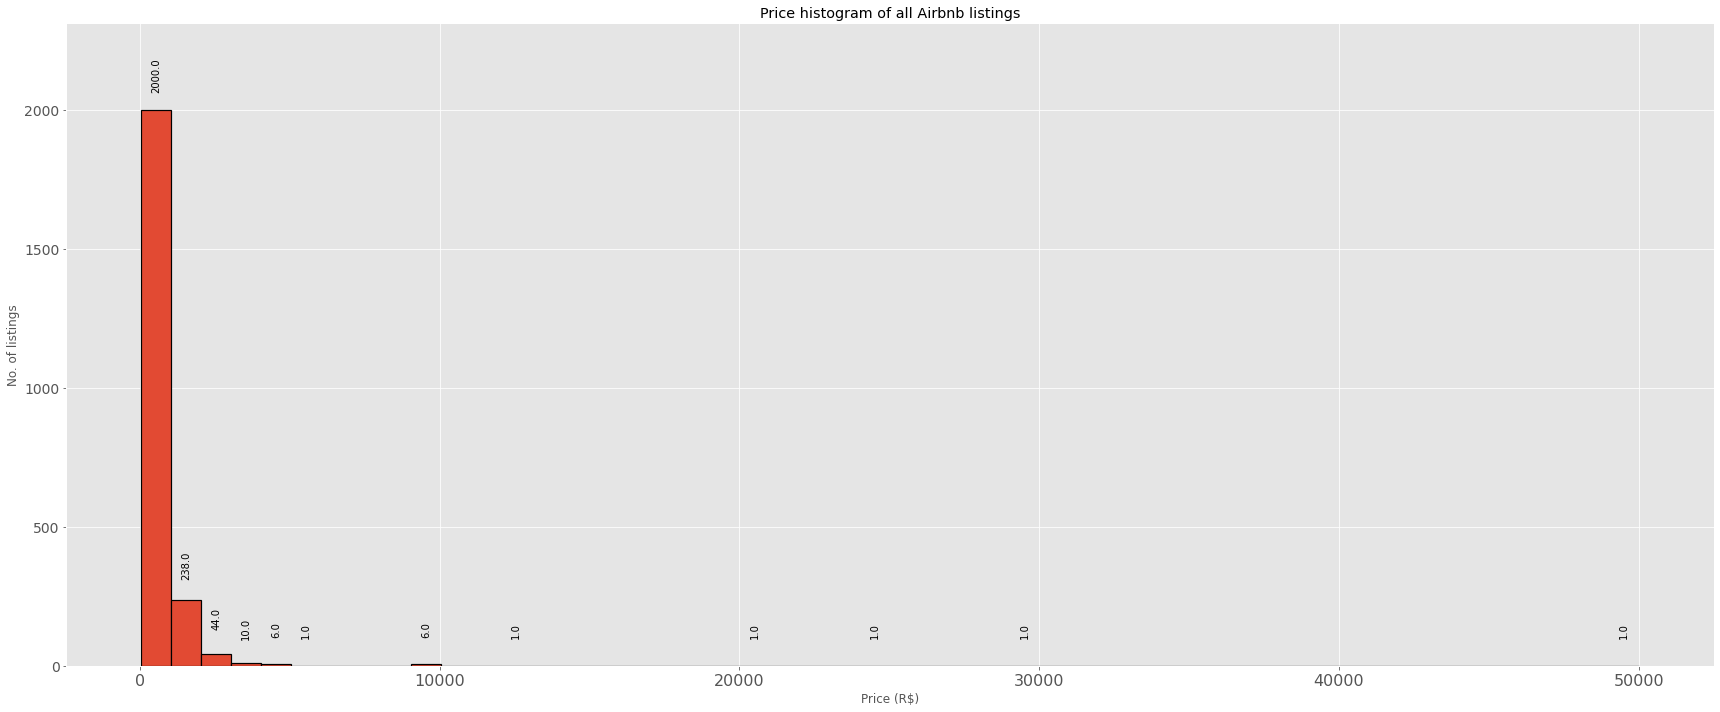

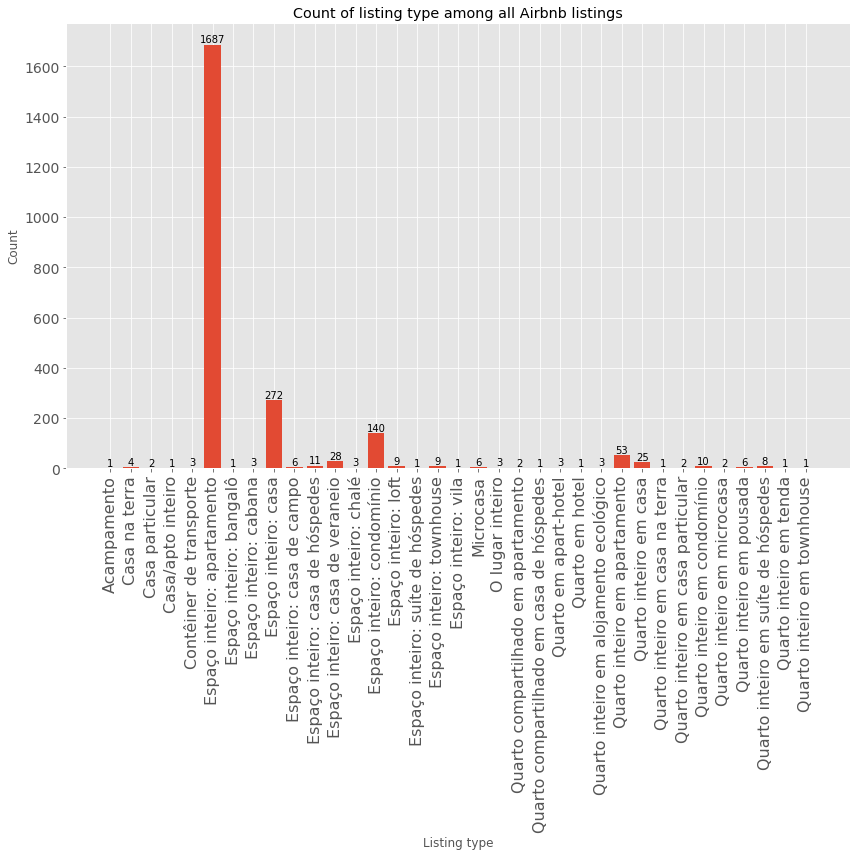

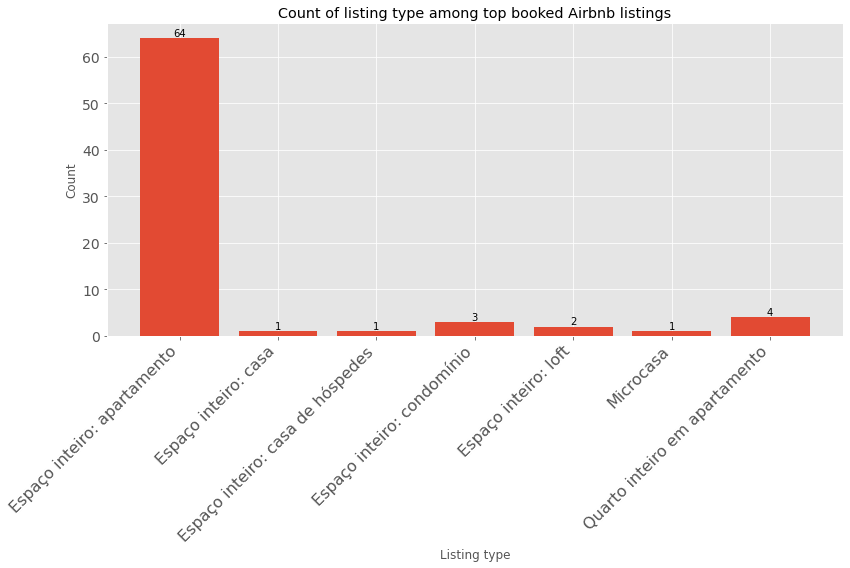

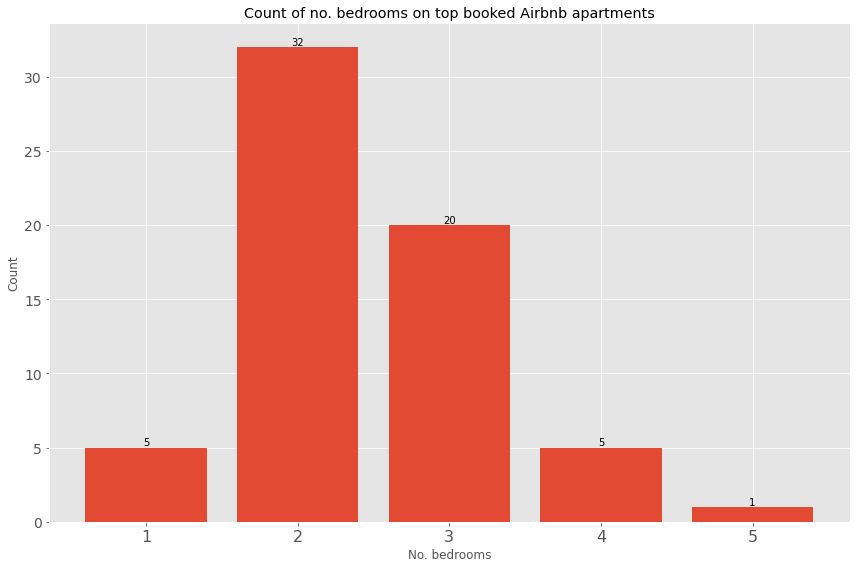

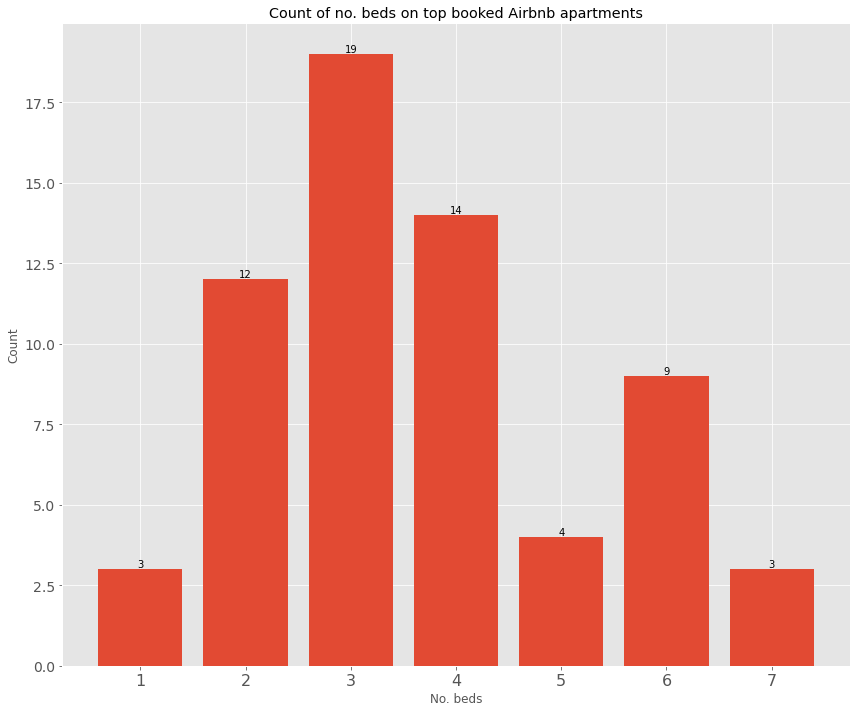

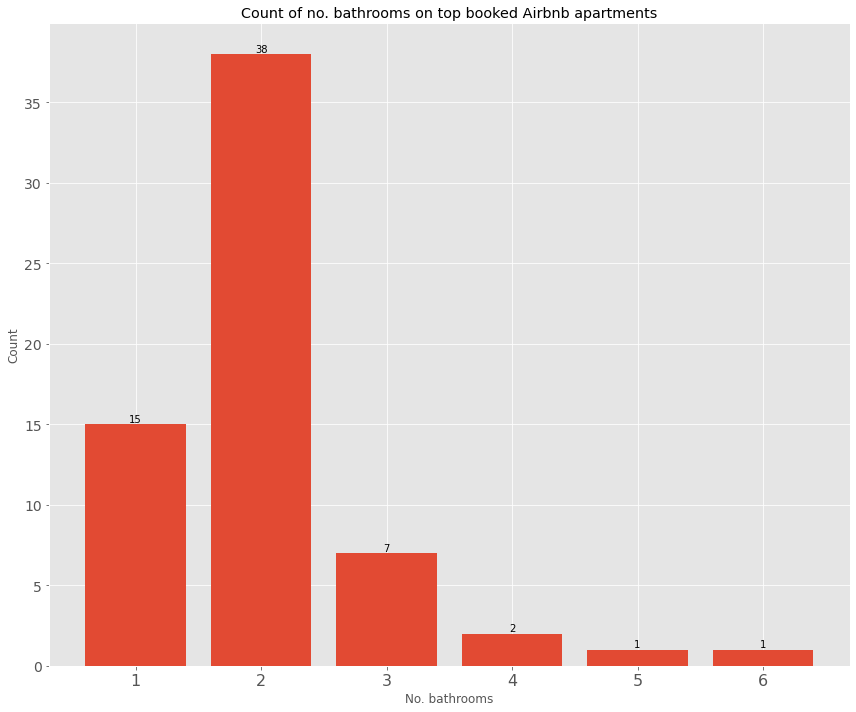

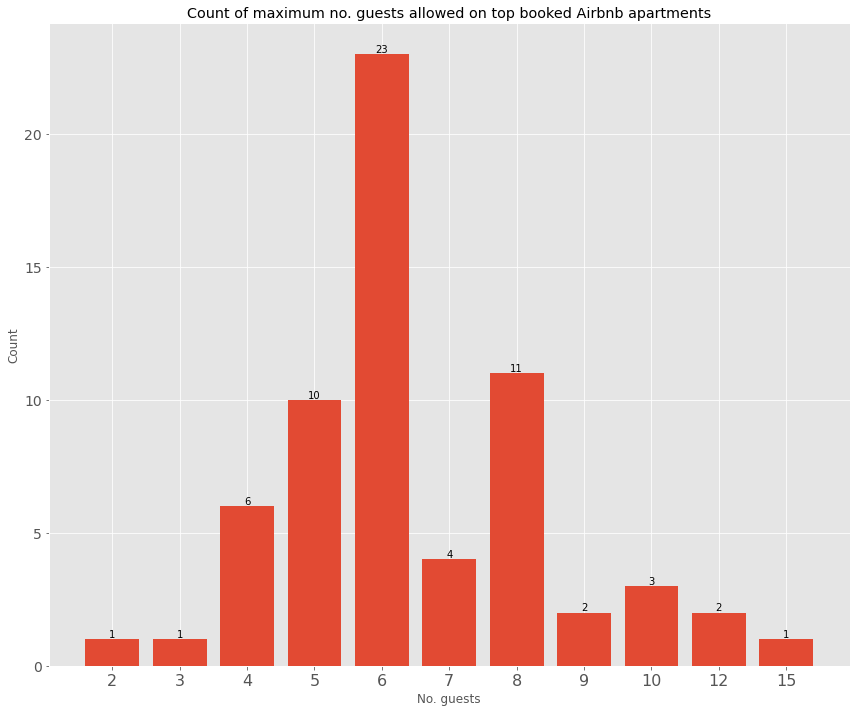

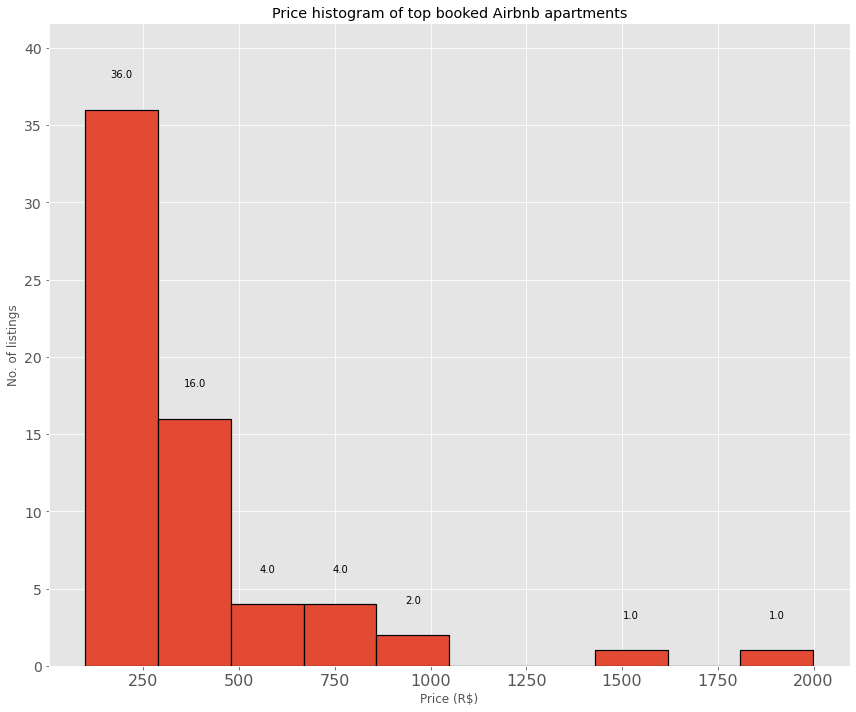

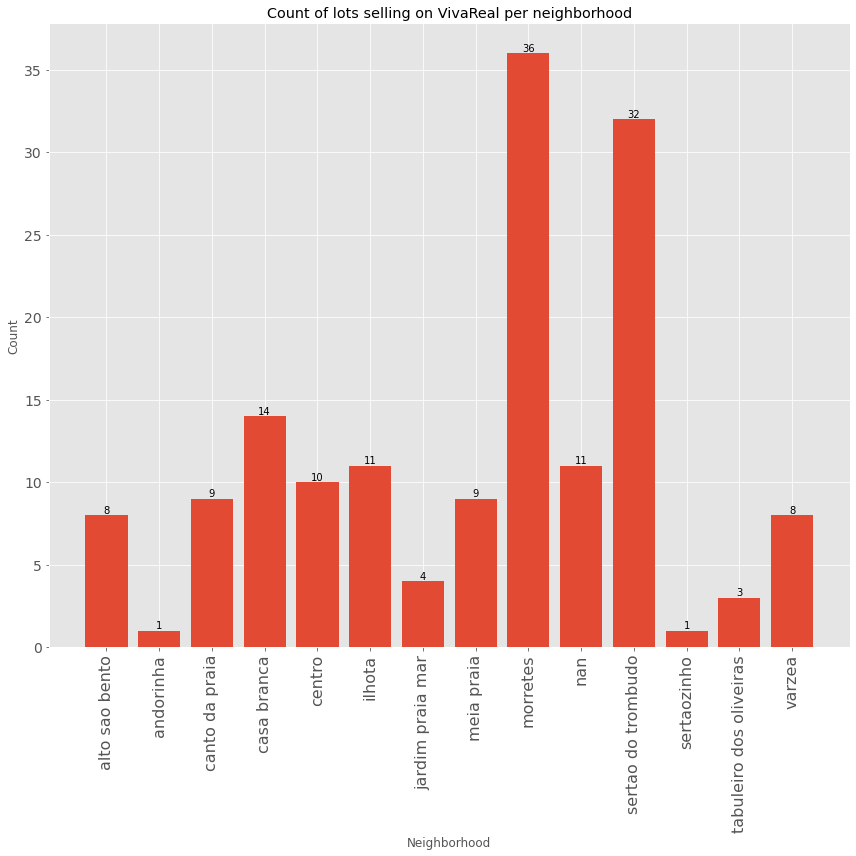

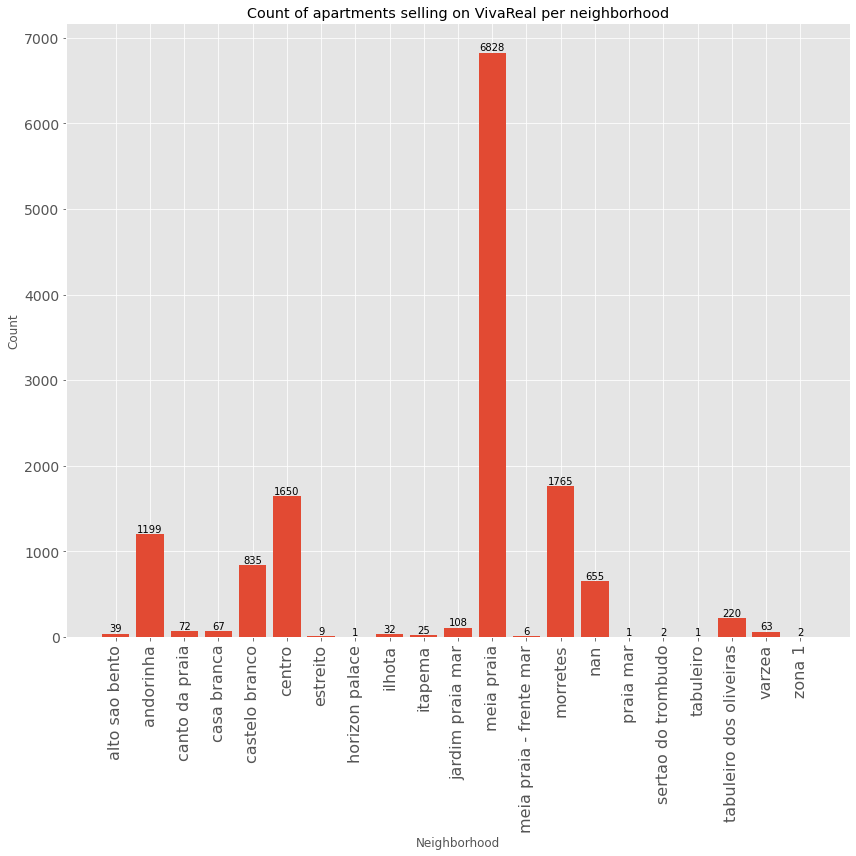

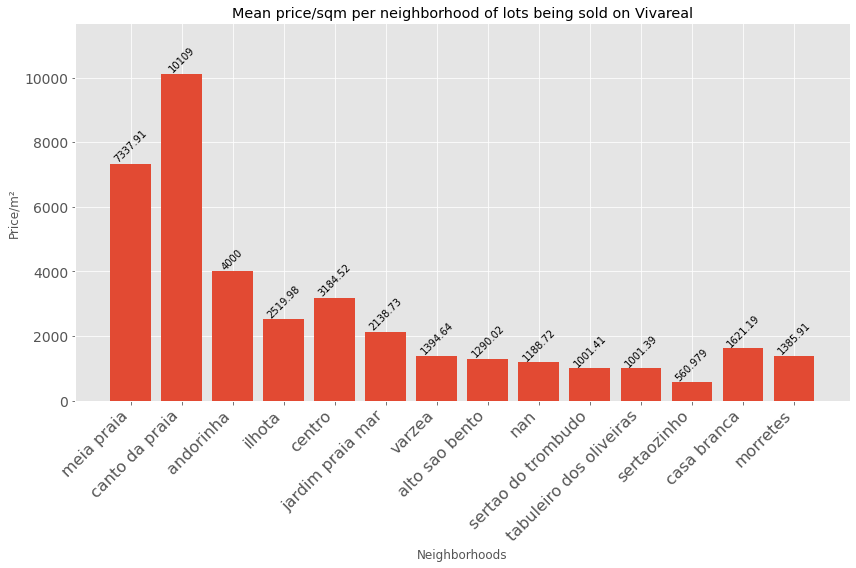

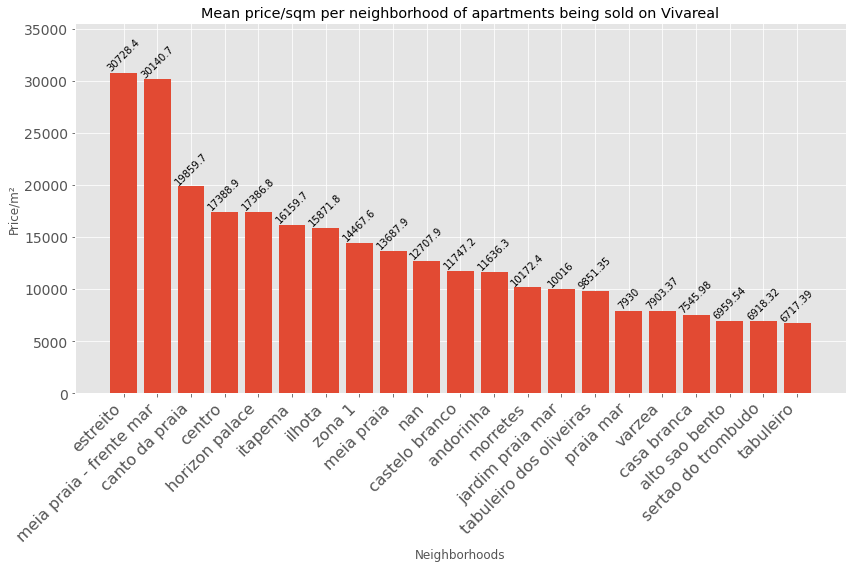

/tmp/ipykernel_66942/1562231927.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)


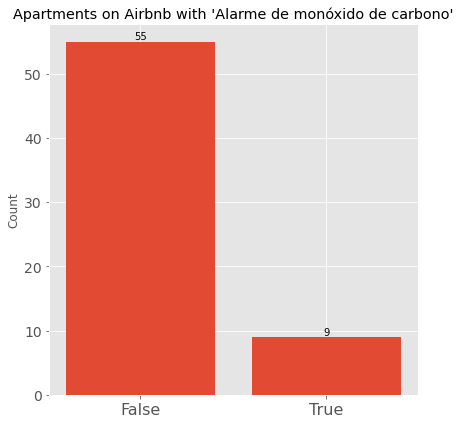

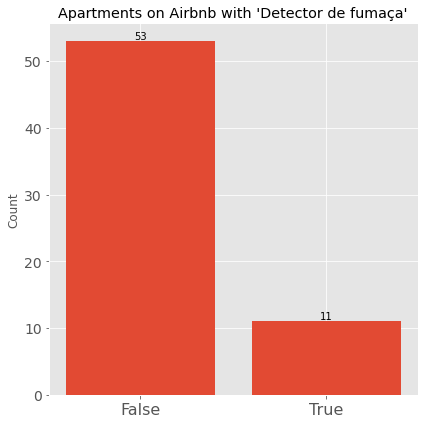

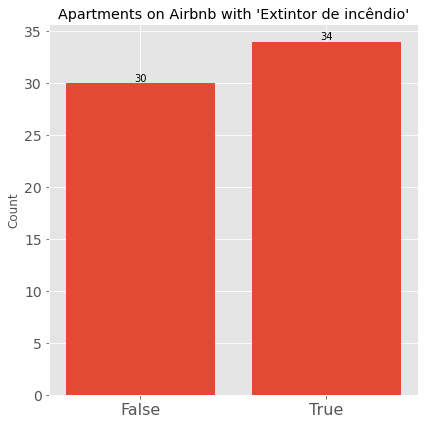

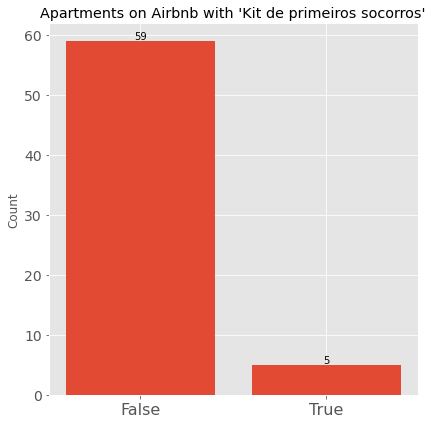

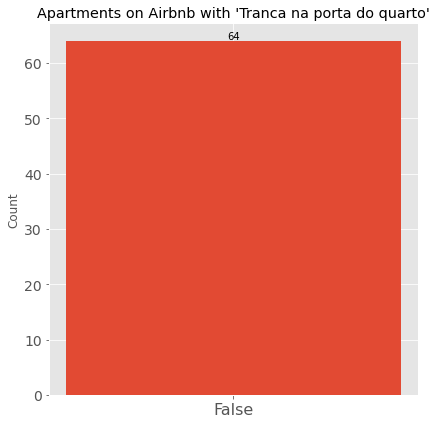

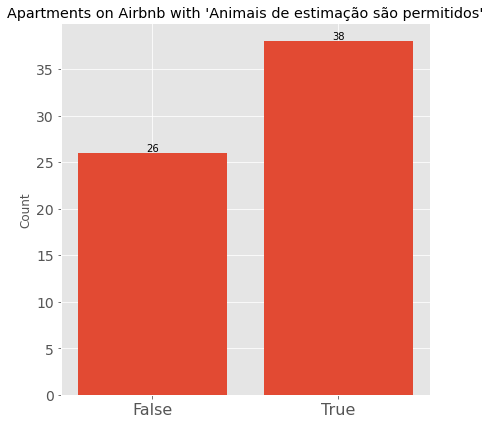

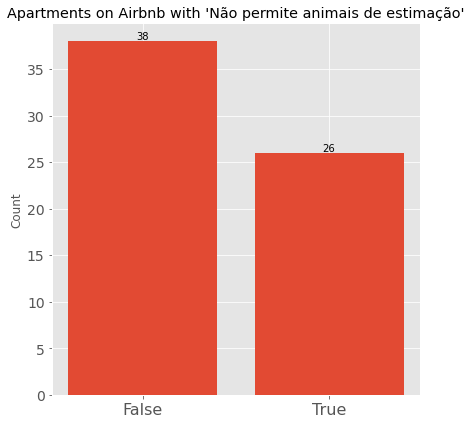

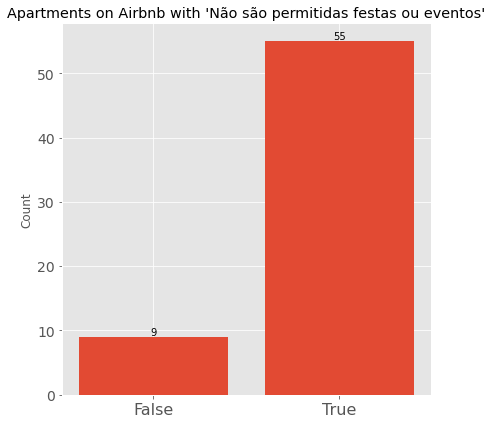

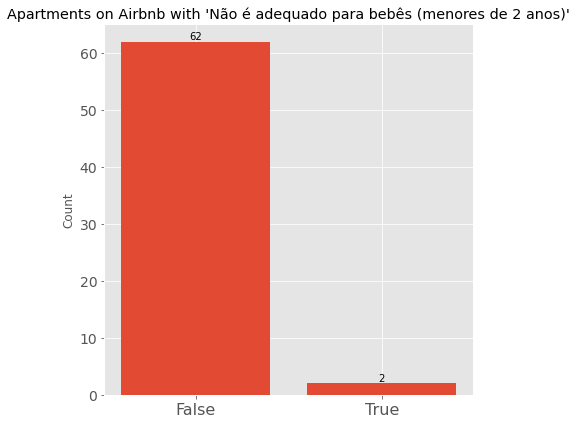

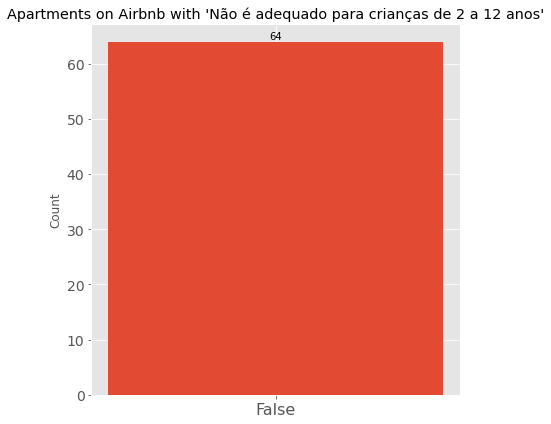

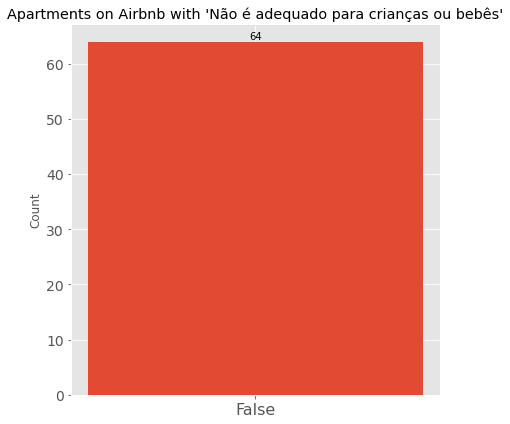

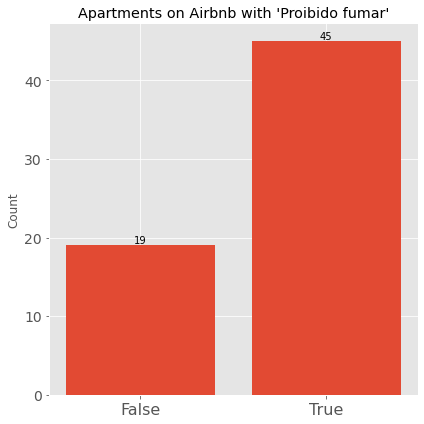

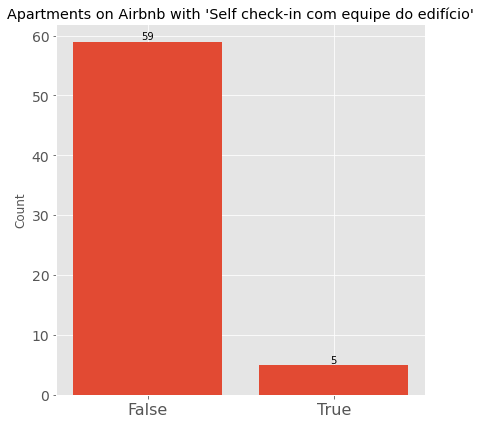

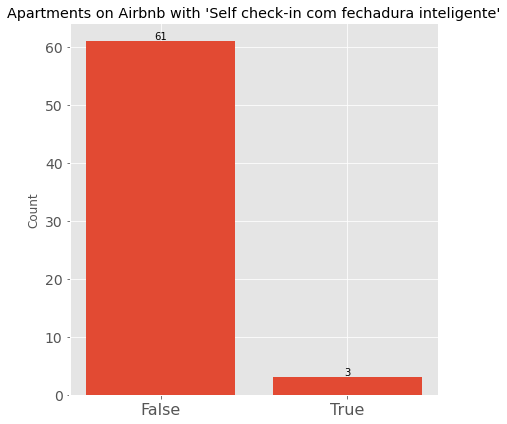

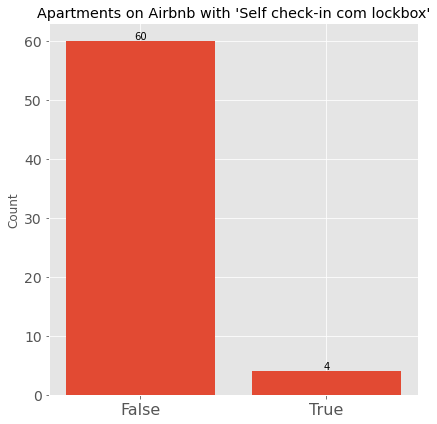

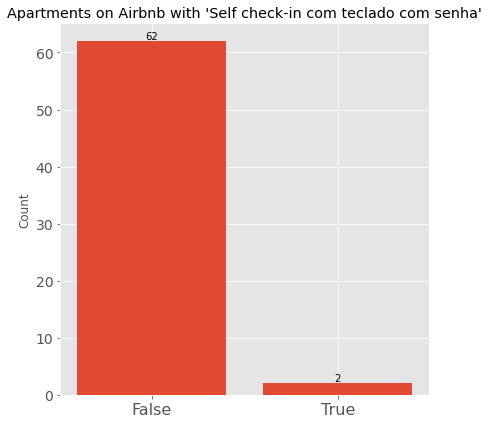

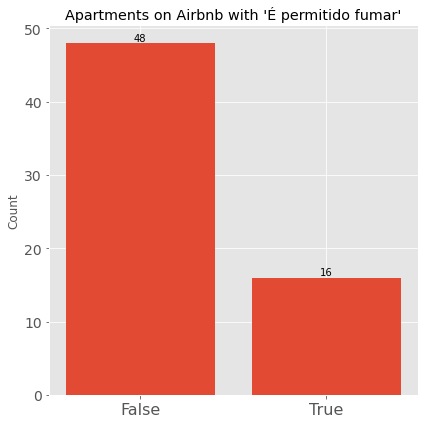

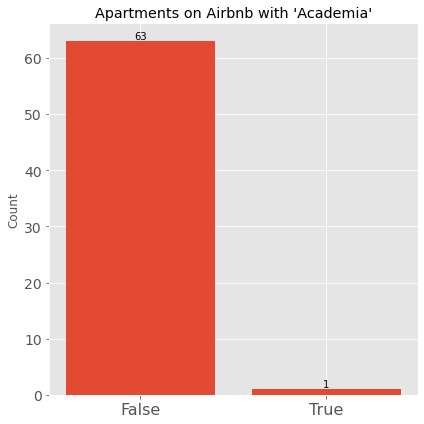

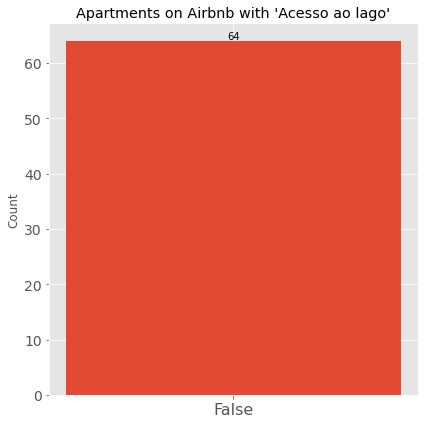

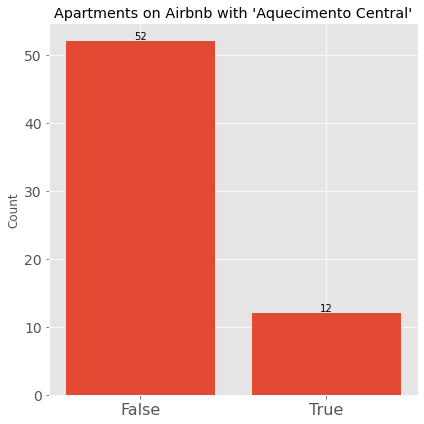

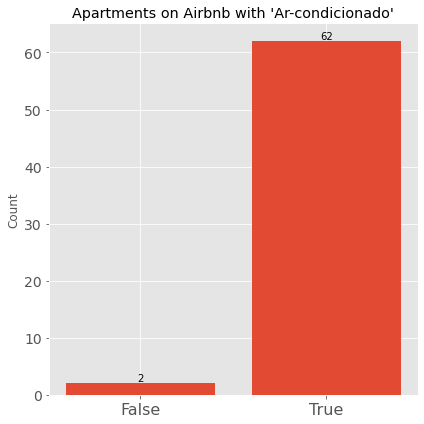

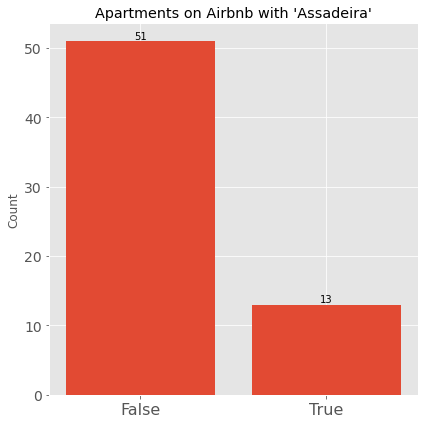

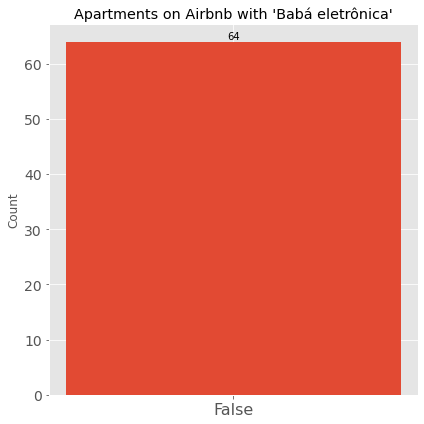

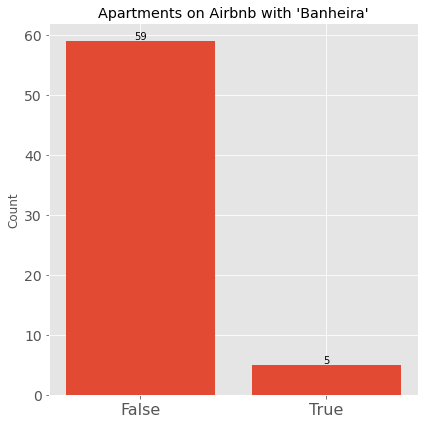

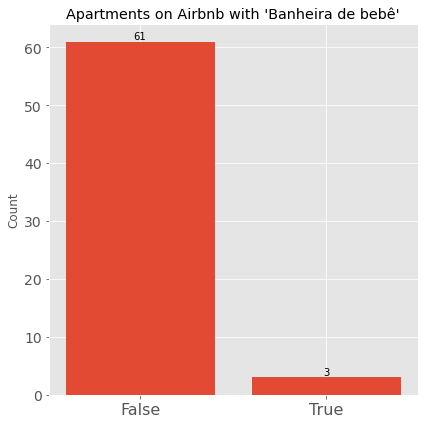

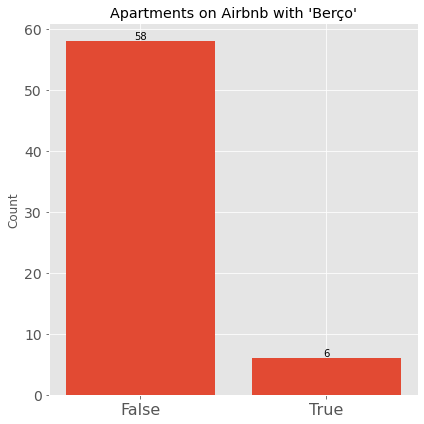

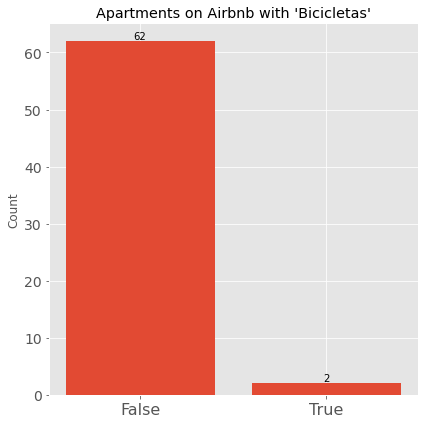

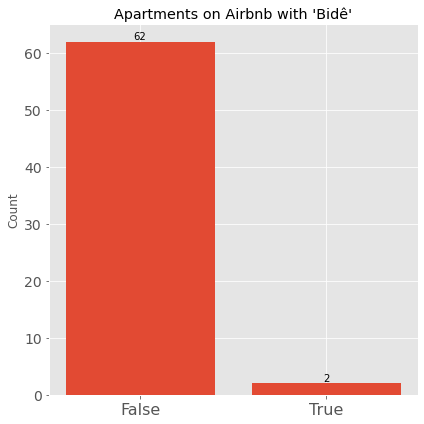

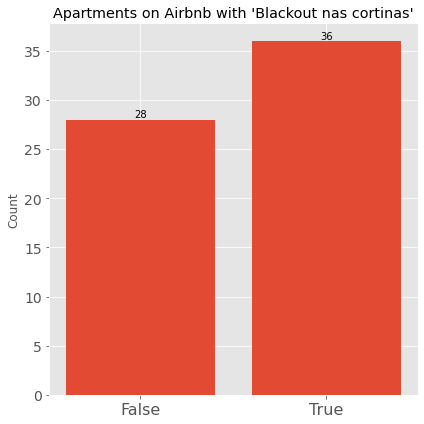

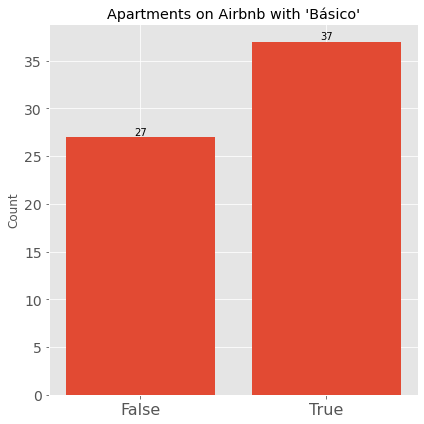

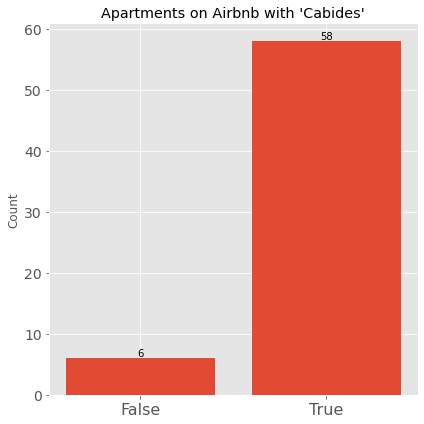

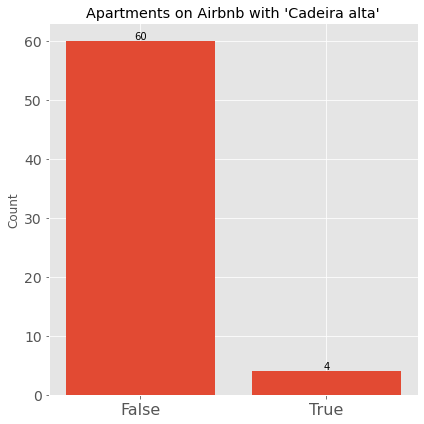

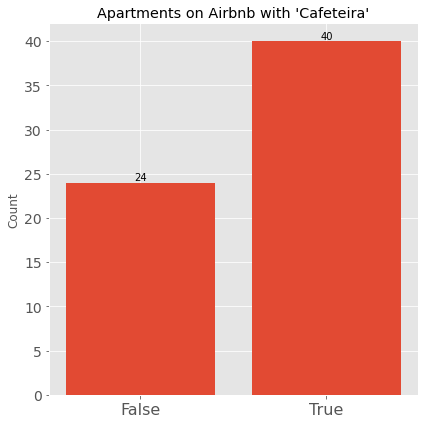

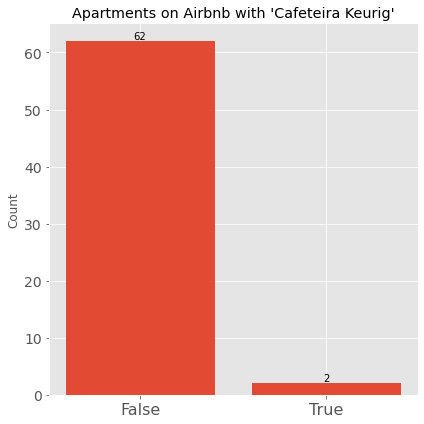

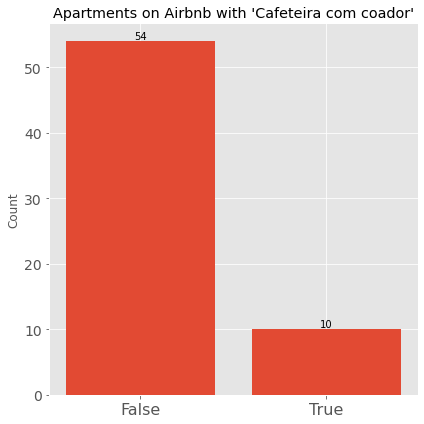

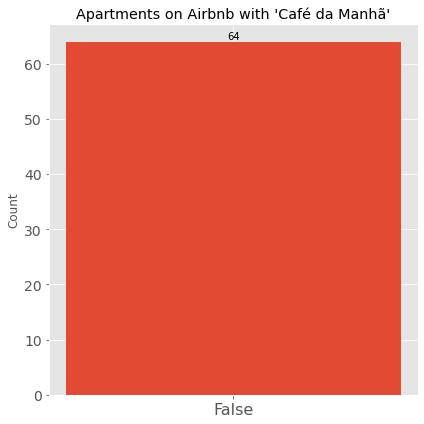

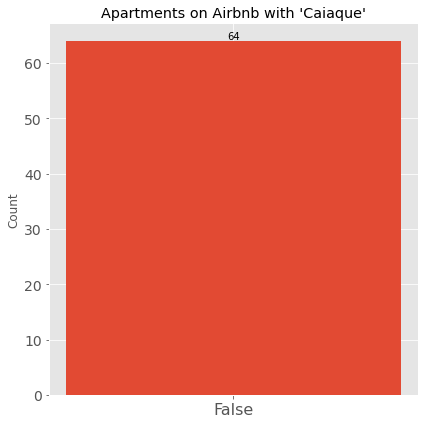

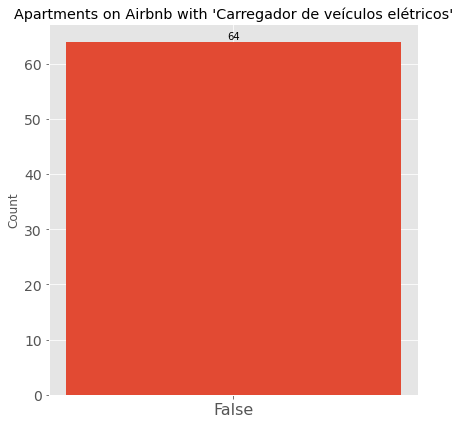

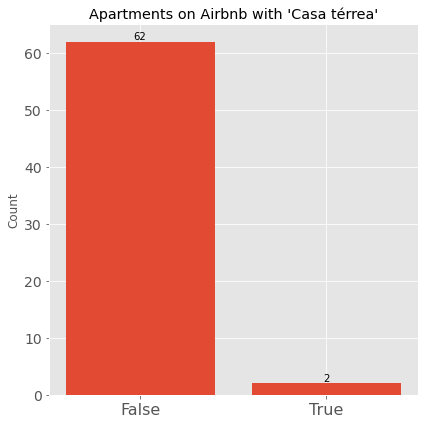

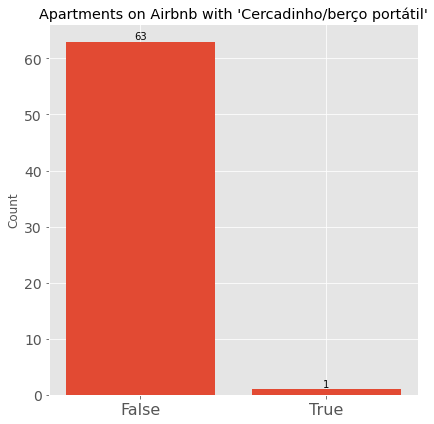

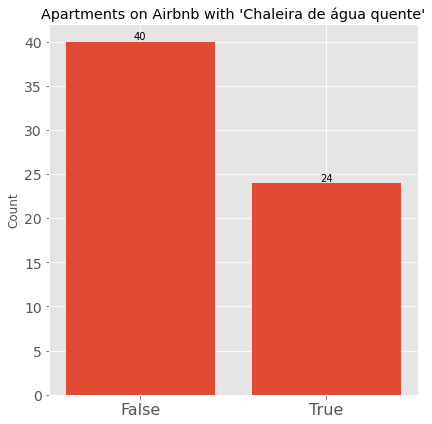

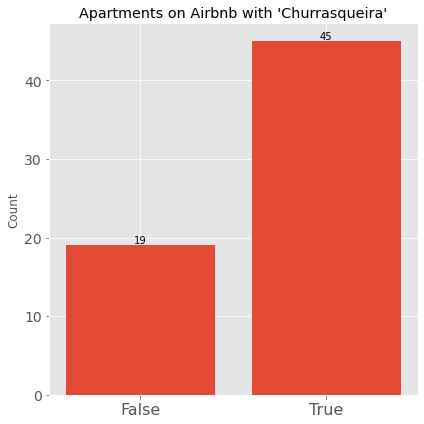

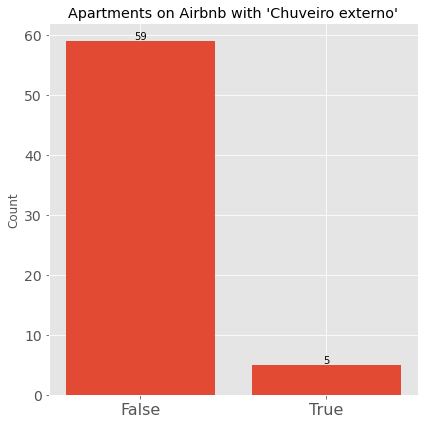

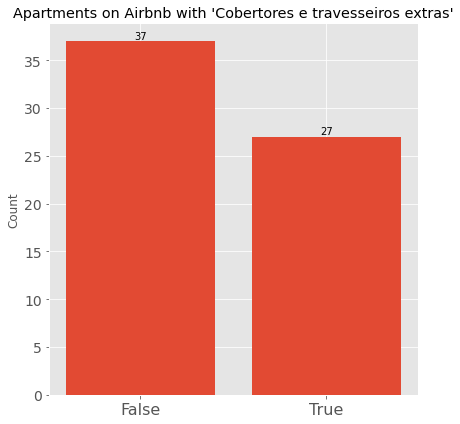

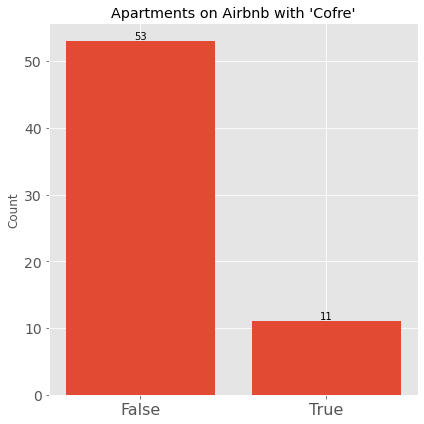

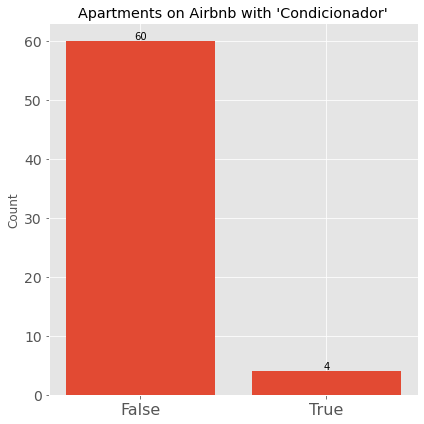

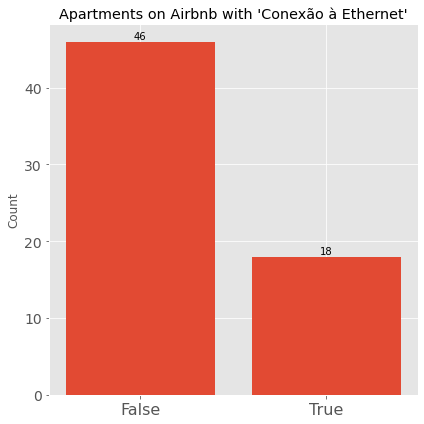

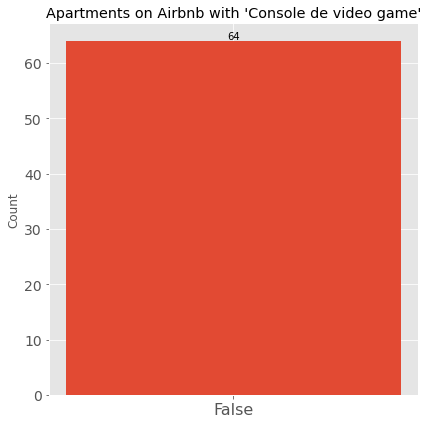

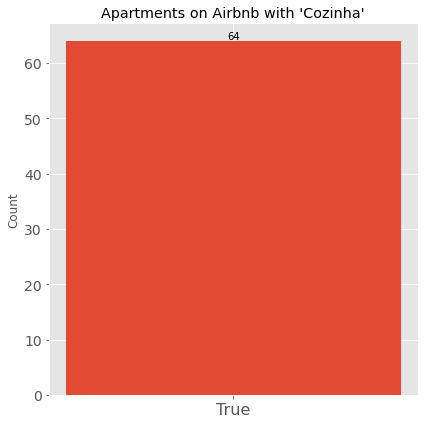

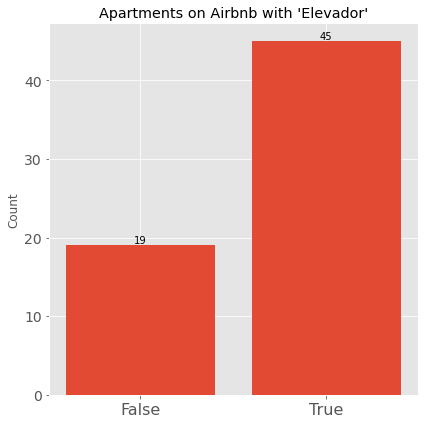

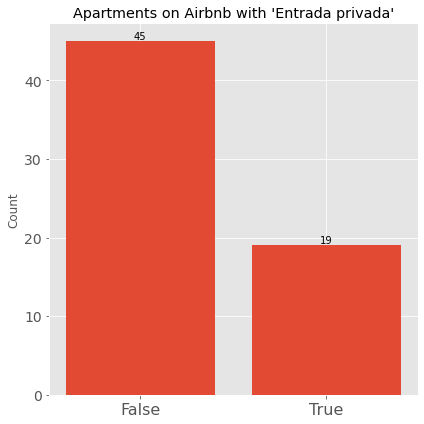

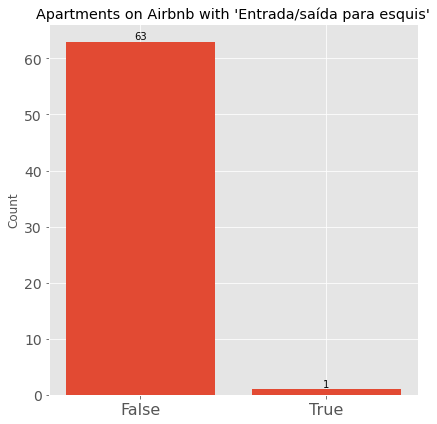

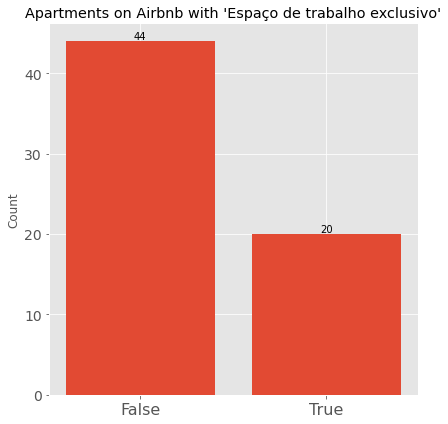

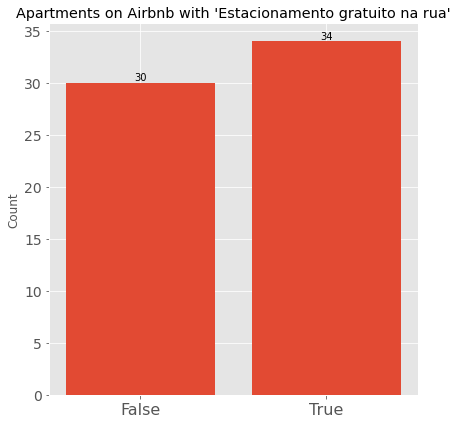

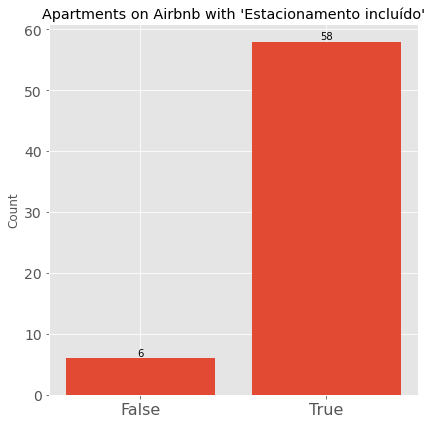

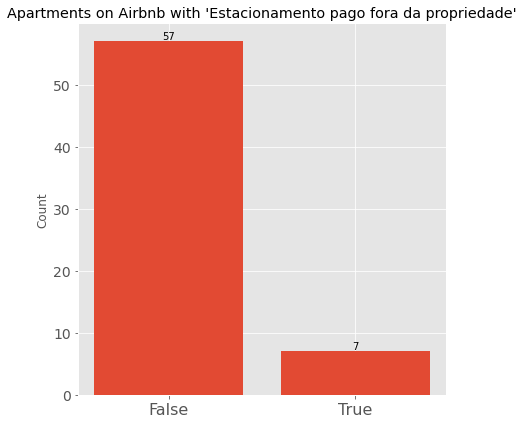

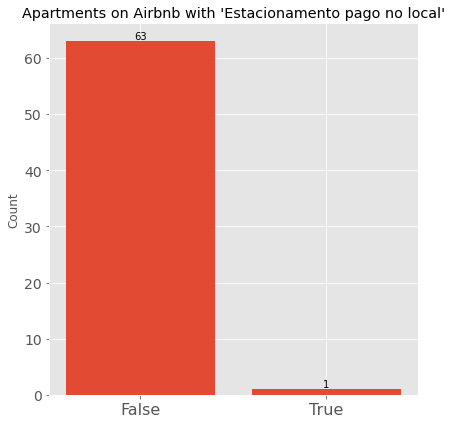

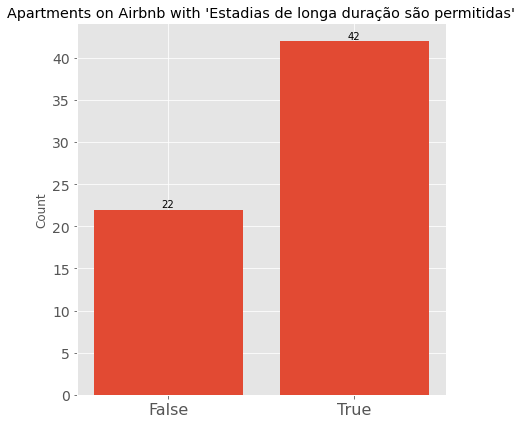

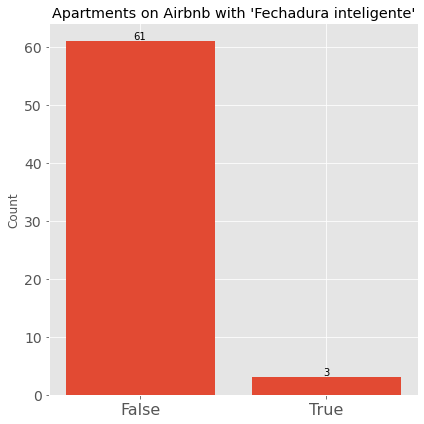

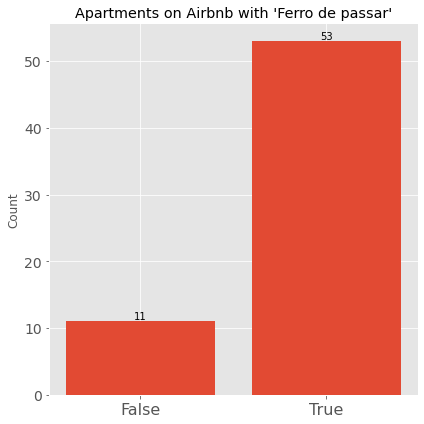

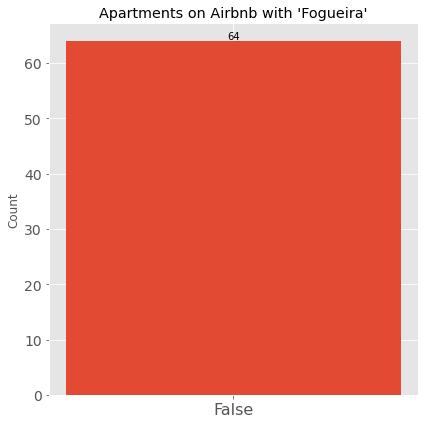

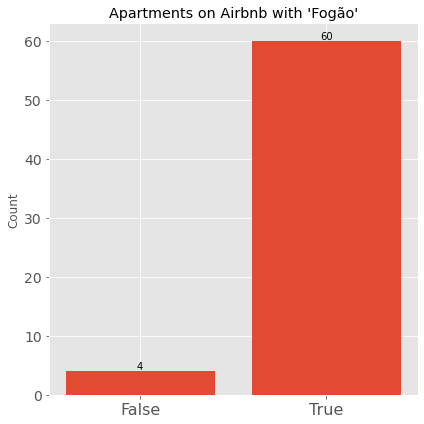

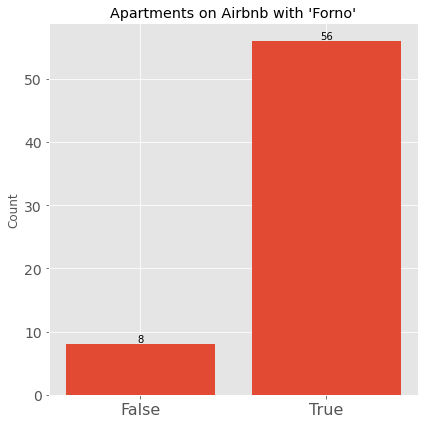

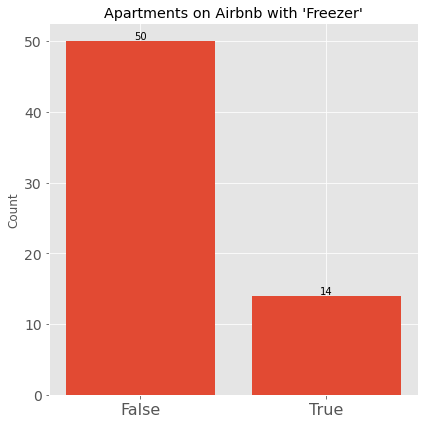

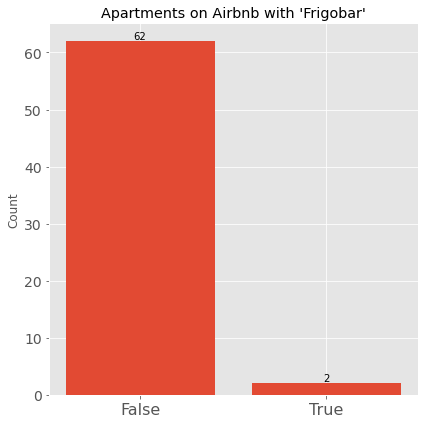

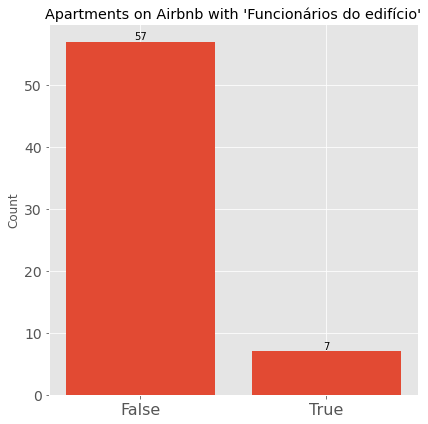

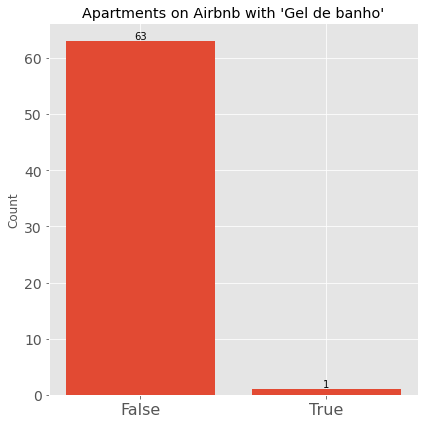

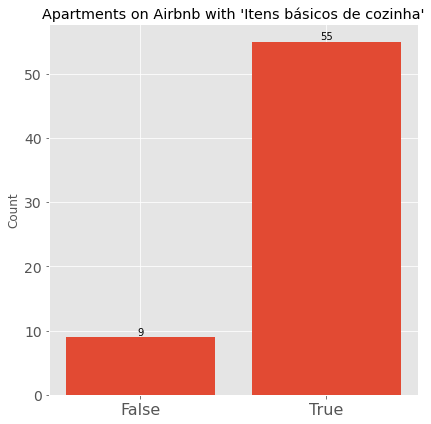

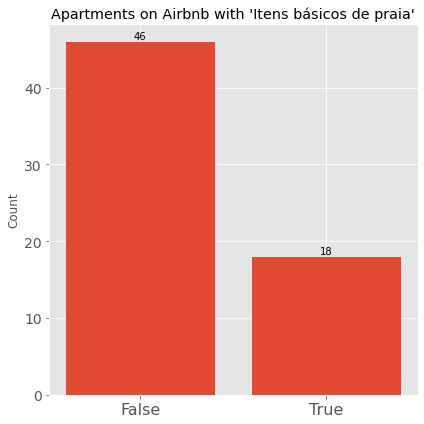

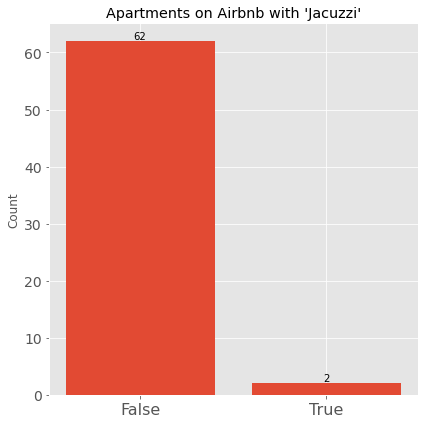

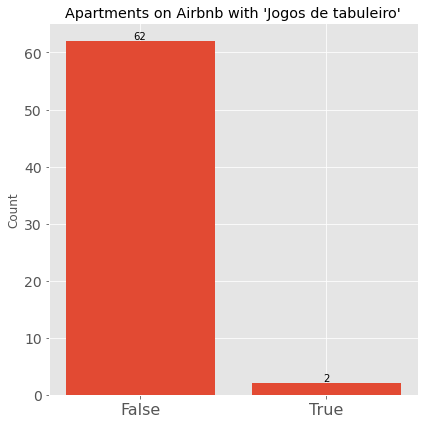

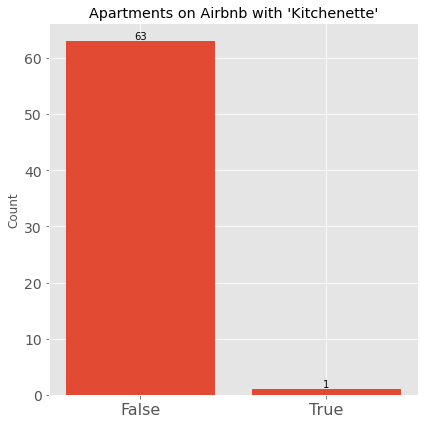

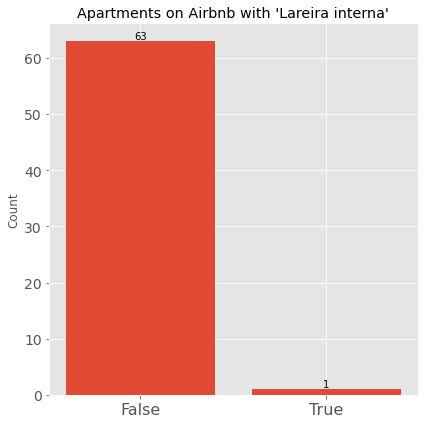

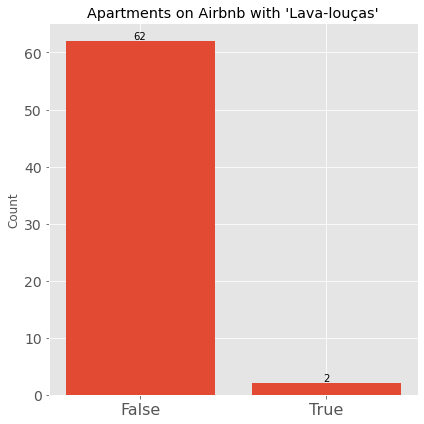

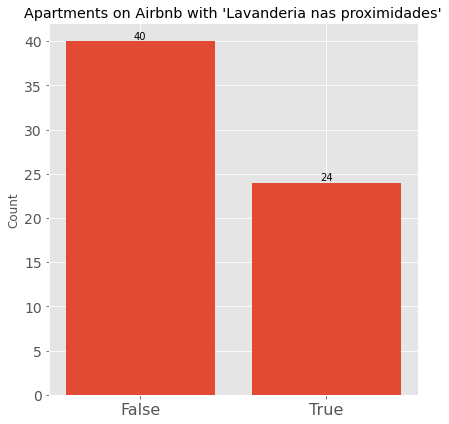

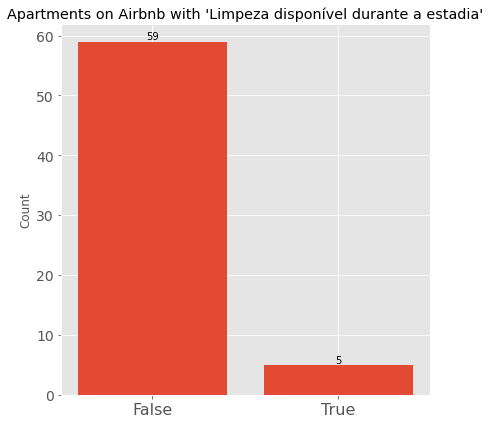

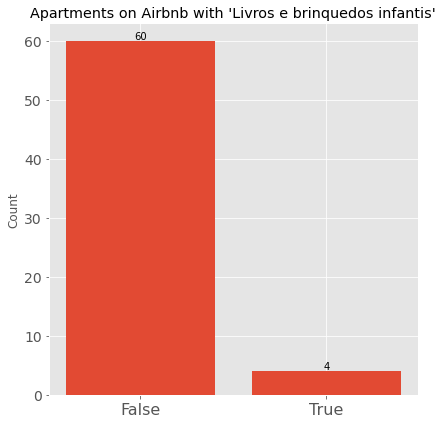

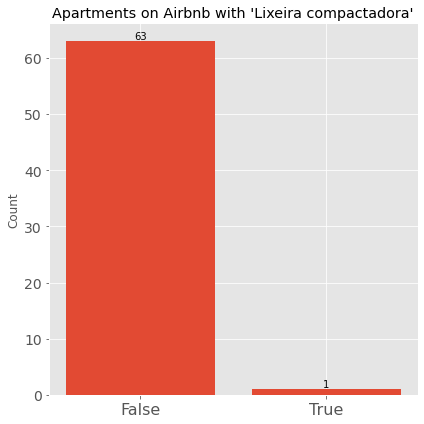

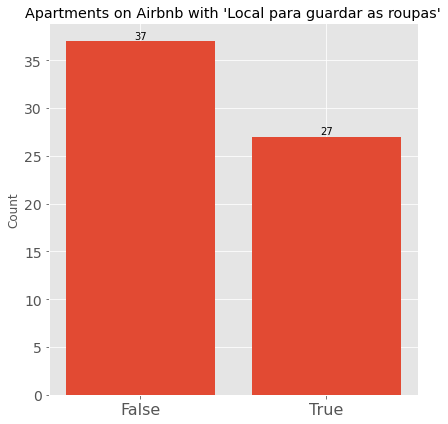

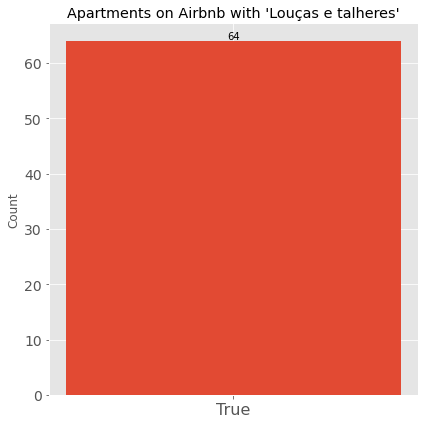

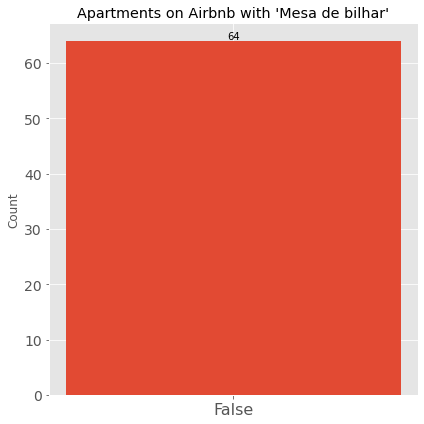

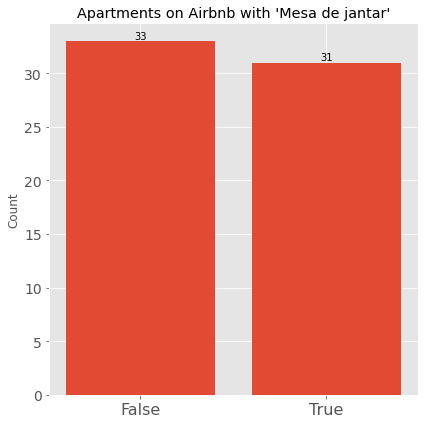

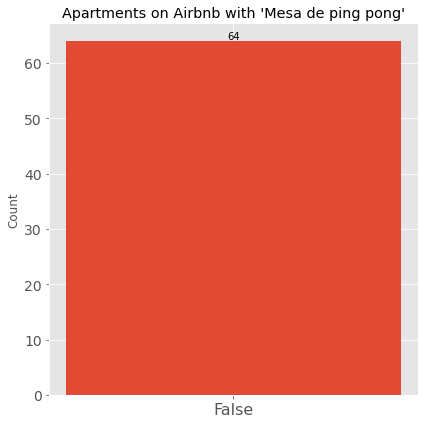

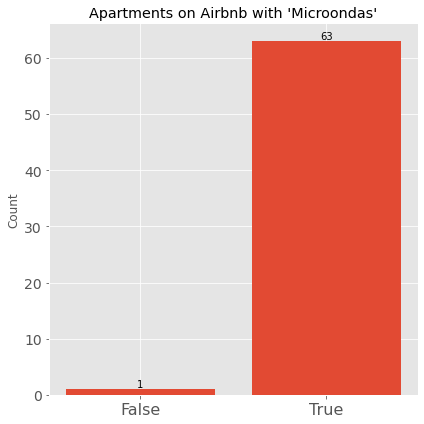

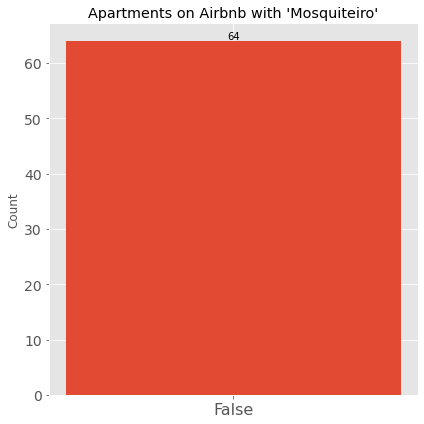

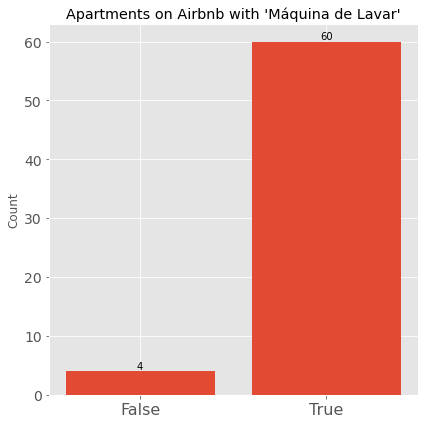

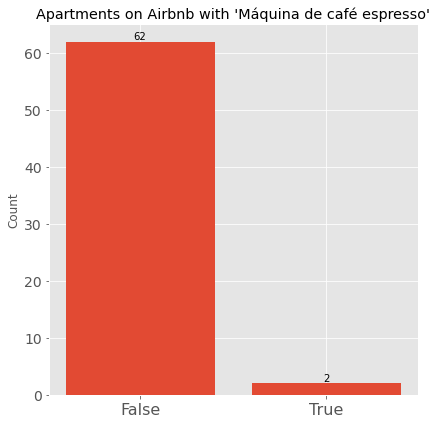

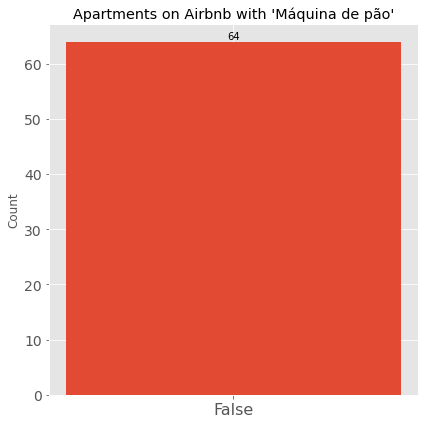

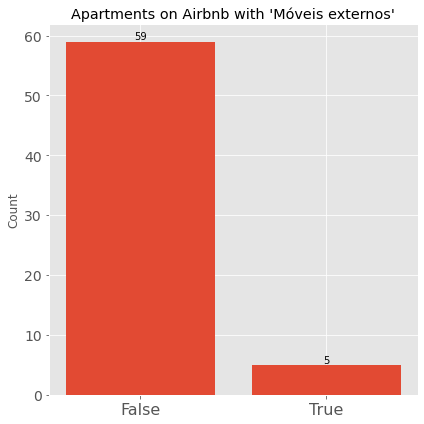

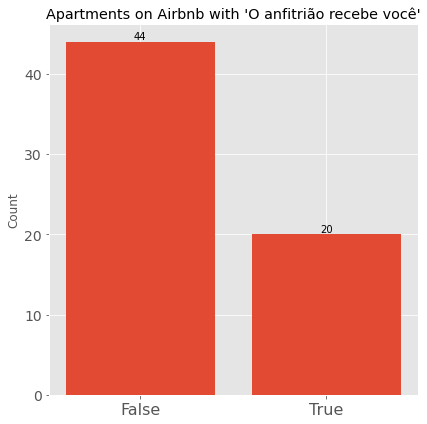

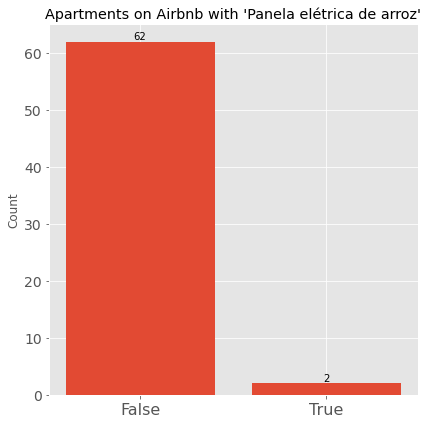

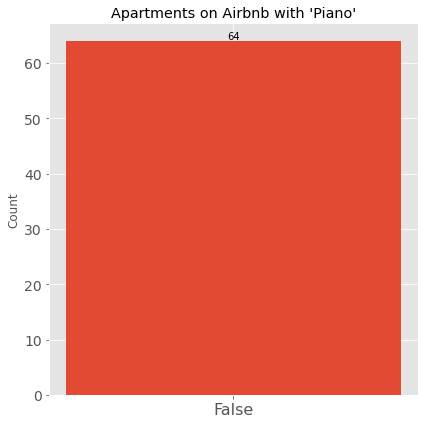

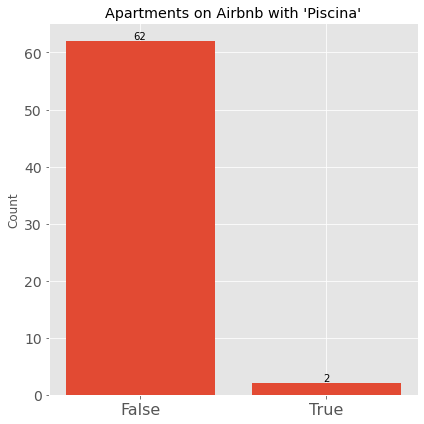

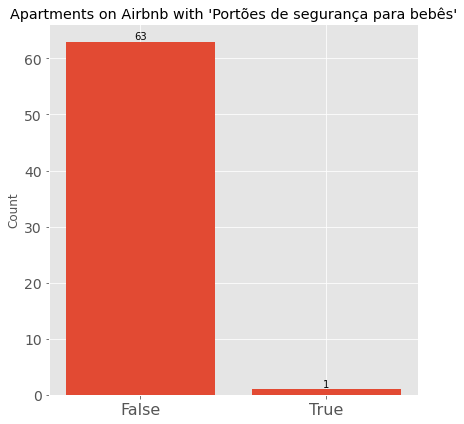

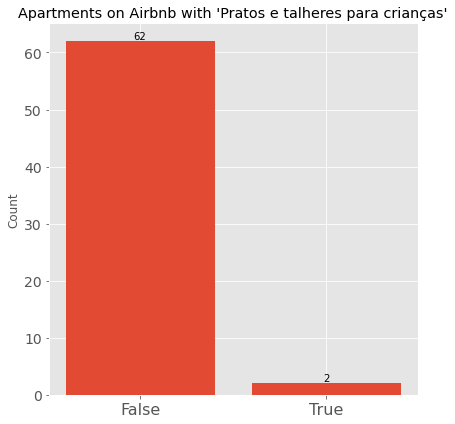

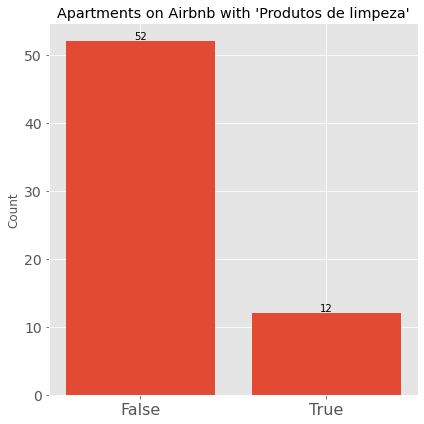

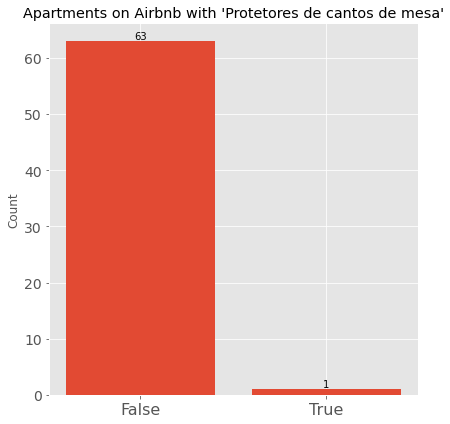

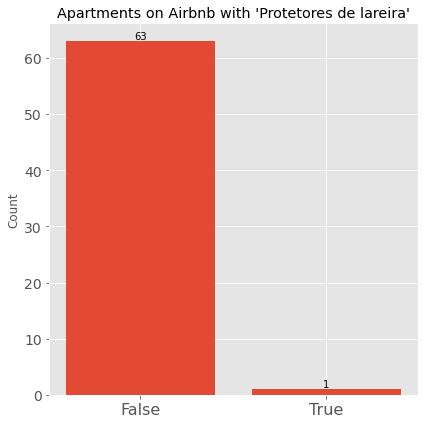

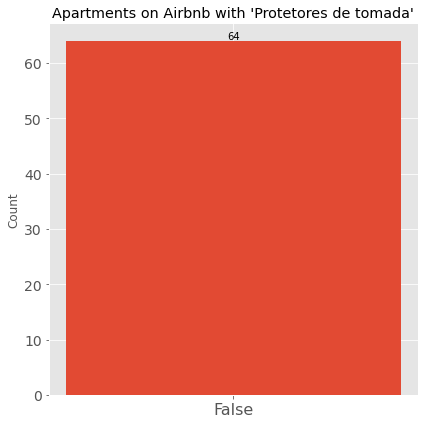

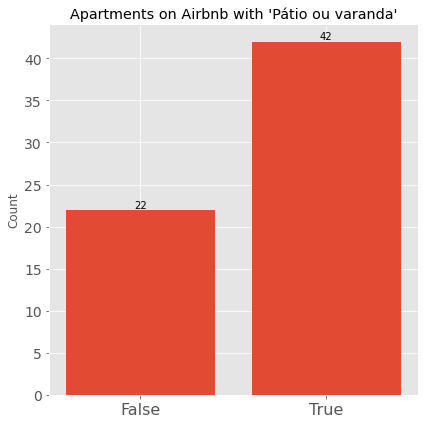

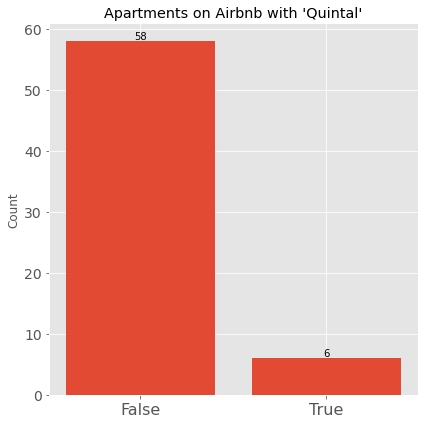

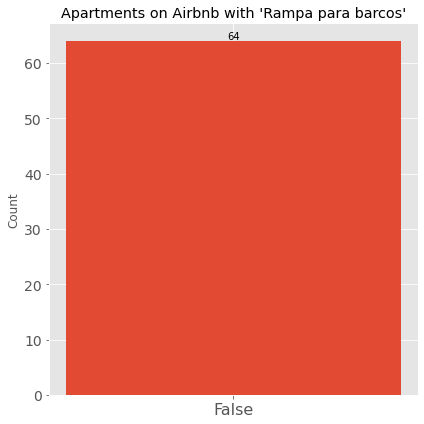

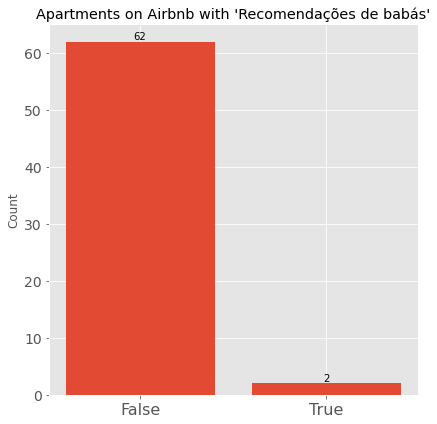

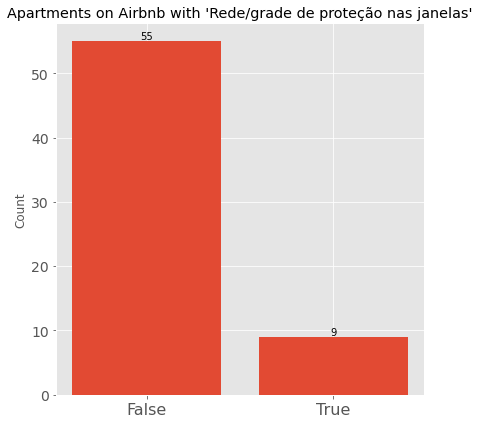

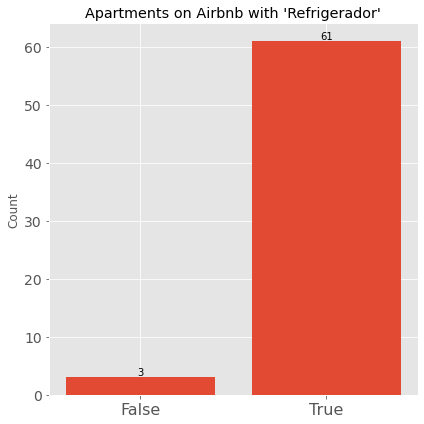

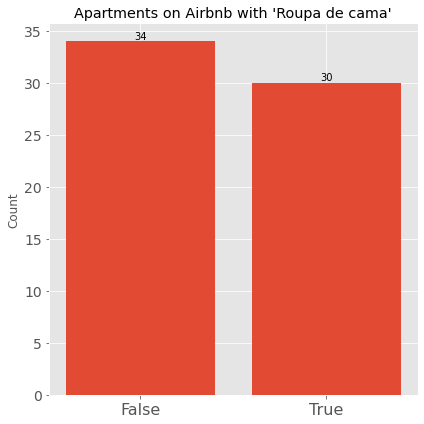

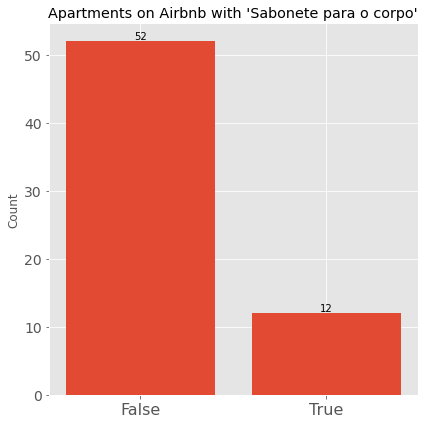

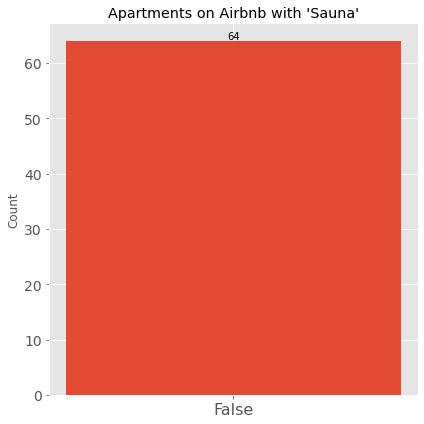

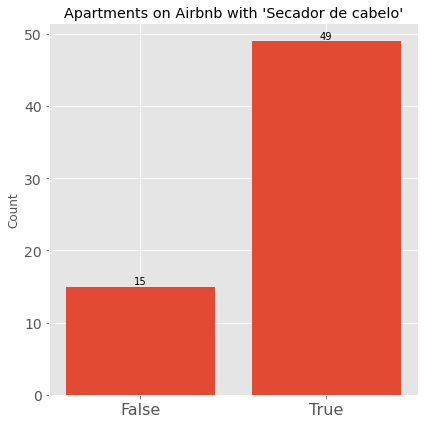

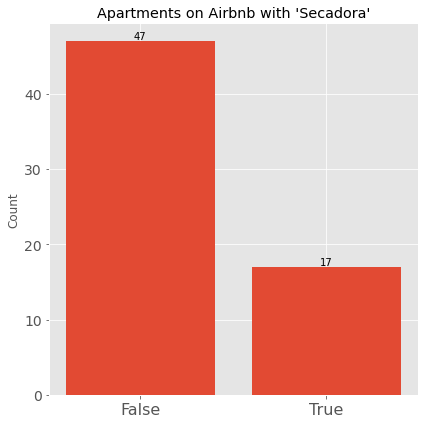

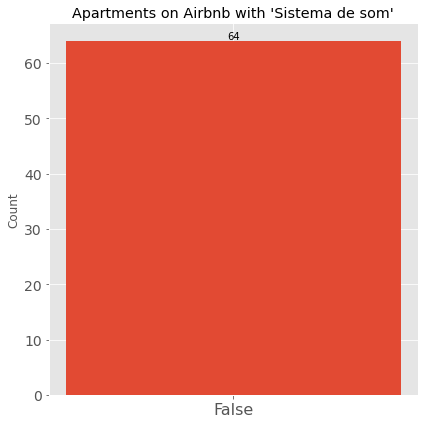

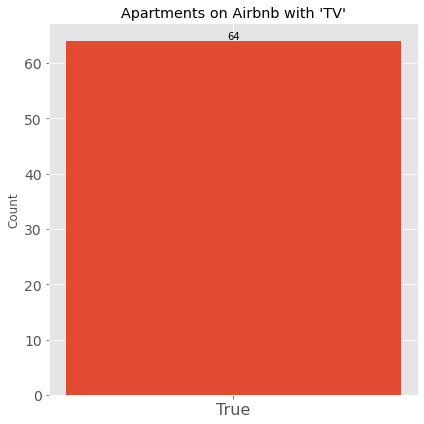

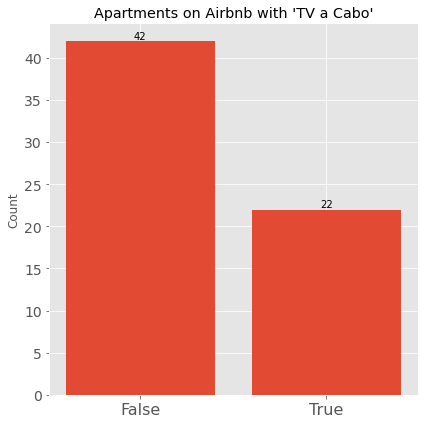

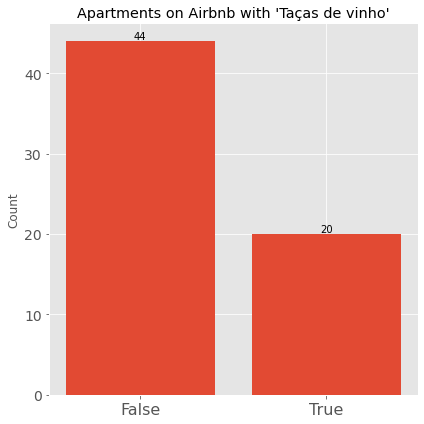

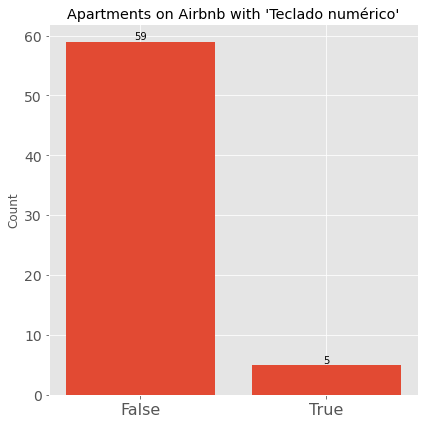

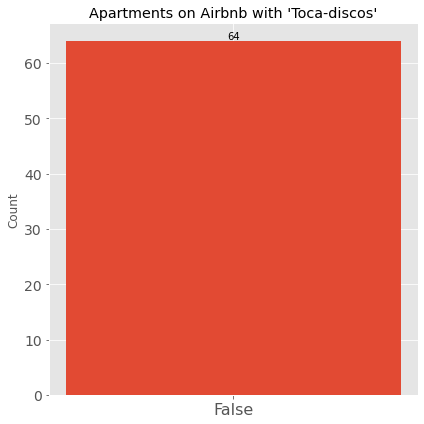

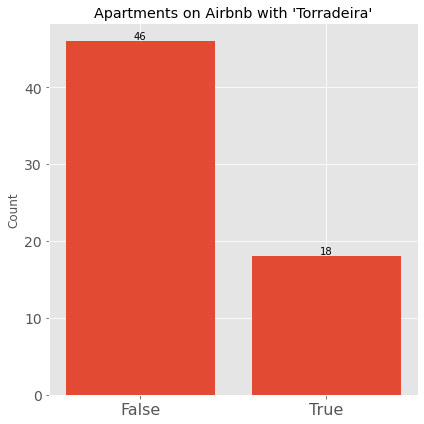

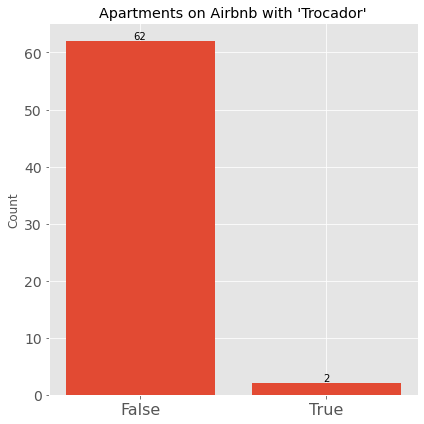

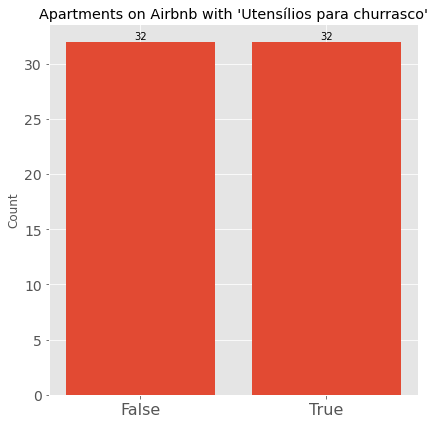

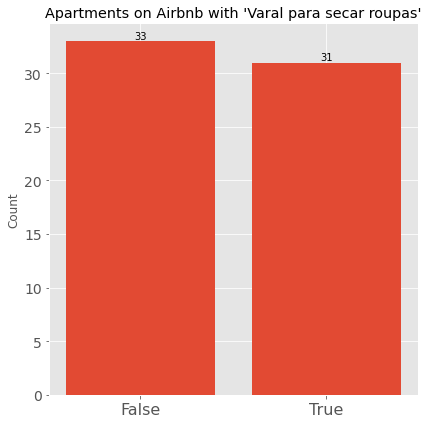

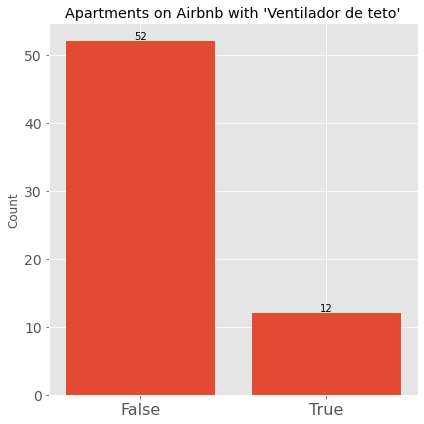

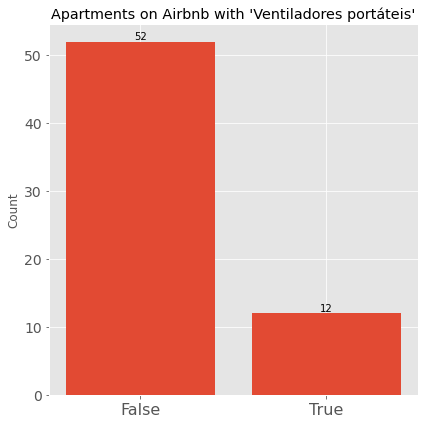

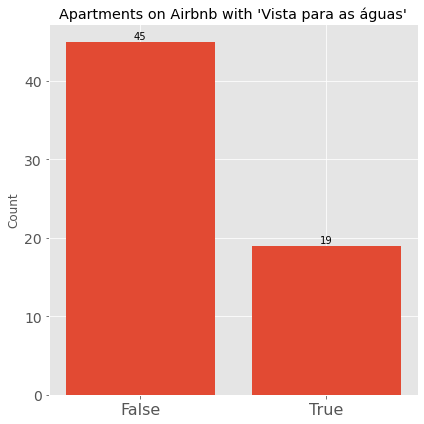

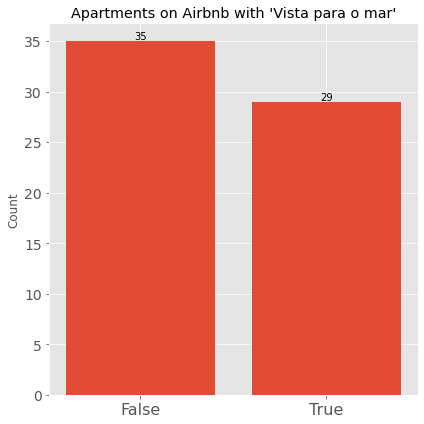

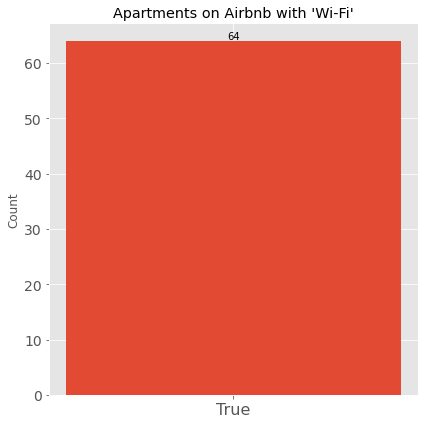

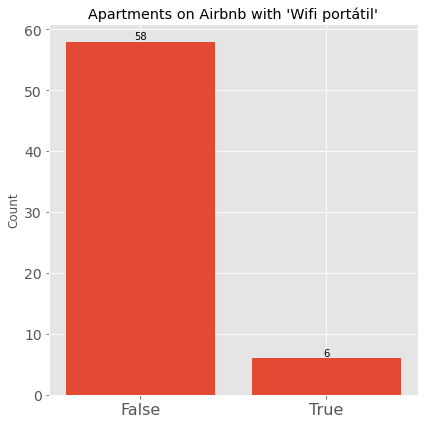

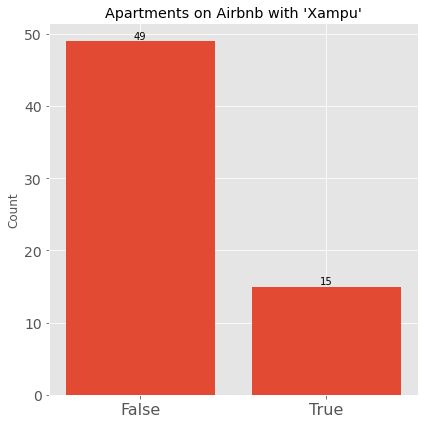

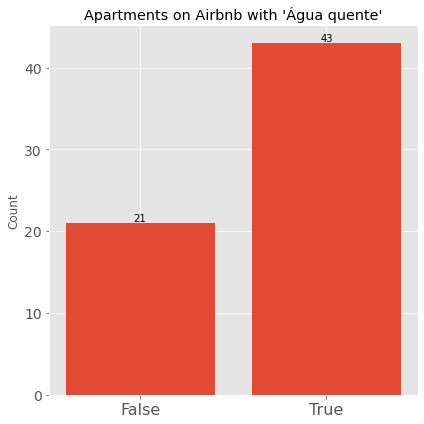

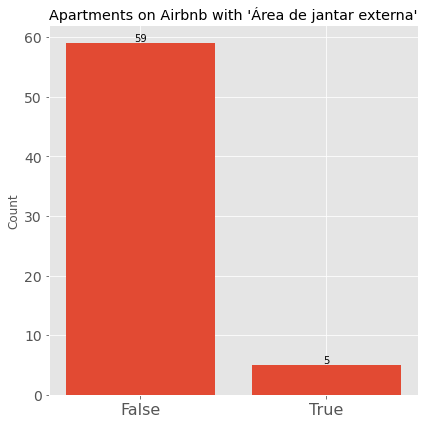

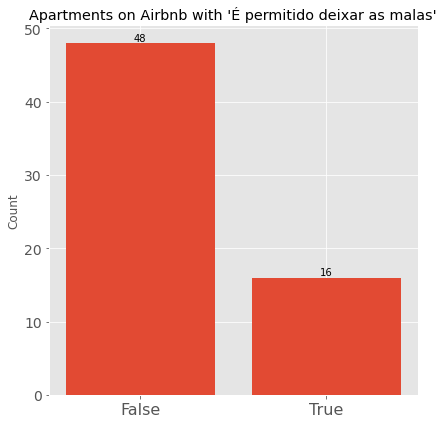

In [81]:
airbnb_listings, \
encoded_columns, \
least_available_airbnb_listings, \
least_available_airbnb_apartments, \
top_booked_airbnb_listings, \
top_booked_airbnb_apartments, \
airbnb_listings_geohash_p6, \
airbnb_listings_geohash_p7, \
top_booked_airbnb_apartments_geohash_p6, \
top_booked_airbnb_apartments_geohash_p7, \
vivareal_listings, \
vivareal_lots_selling, \
vivareal_apartments_selling, \
vivareal_lots_nbh, \
vivareal_apartments_nbh = \
                        solve_case()

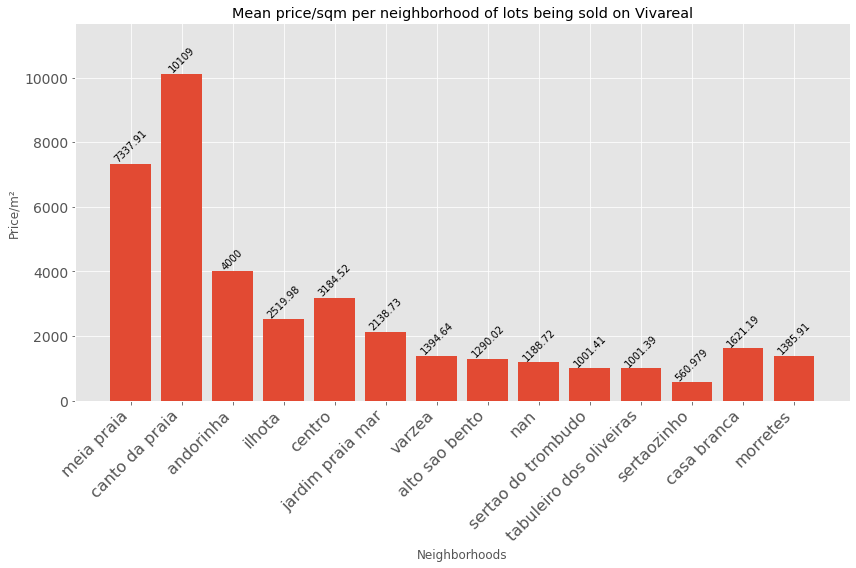

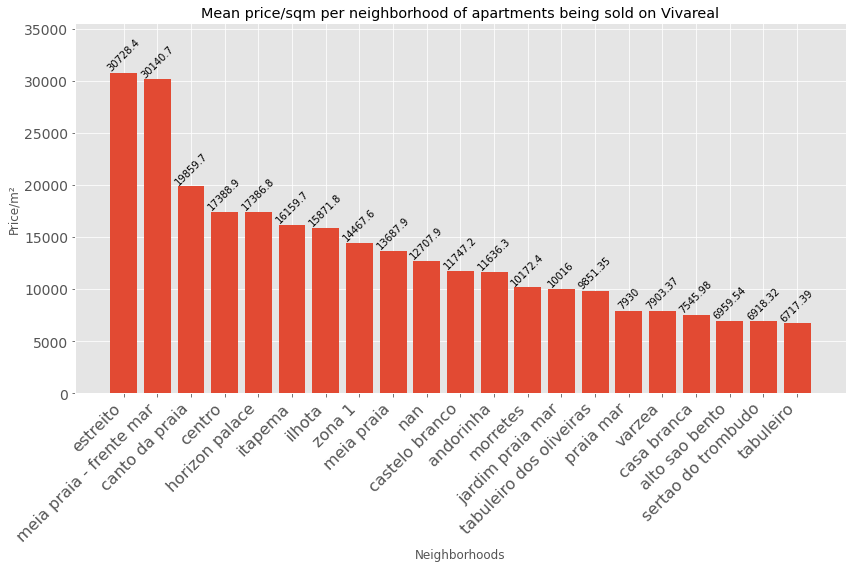

In [71]:
data_analysis(  airbnb_listings,
                encoded_columns,
                least_available_airbnb_listings,
                least_available_airbnb_apartments,
                top_booked_airbnb_listings,
                top_booked_airbnb_apartments,
                airbnb_listings_geohash_p6,
                airbnb_listings_geohash_p7,
                top_booked_airbnb_apartments_geohash_p6,
                top_booked_airbnb_apartments_geohash_p7,
                vivareal_listings,
                vivareal_lots_selling,
                vivareal_apartments_selling,
                vivareal_lots_nbh,
                vivareal_apartments_nbh,
                show_plots = False)

In [51]:
# To answer question 1 -> assumption: I already made the assumption that (1) "best" is closely related to a low vacancy rate and (2) vacancy is directly related to "number_of_reviews"
# analyze the numerical variables: number of bedrooms, beds, bathrooms, number of guests, parking spaces (?), size of the apartment etc (maybe histograms?) - ok!
# analyze the categorical variables: sea view, pets, appliances  (barplots)
# analyze the price: histogram of price - ok!
# analyze the location: cool if I could plot it on top of maps of Itapema -> this is part of question 2, so I will answer it there
# analyze the architecture, furniture (pictures?)

# To answer question 2 ->
# Calculate the median/mean of price and number_of_reviews for different locations (would be great to divide the city drawing areas in the map, and check if lat/lon is inside that area, so that I can calculate distance to the beach)# select one with a good balance of revenue vs number_of_reviews

# To answer question 3 ->
# Just use the same analysis that we used on question 1, but over the area selected on question 2

### Answering Question 1
Listing type: Apartment

Bedrooms: 1, 2 or 3

Beds: 1, 2, 3 or 4

Bathrooms: 1 or 2

Encoded features: 


In [32]:
# python -m src.data.format_data